In [499]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)
import pmdarima as pm
import datetime
import math
from sklearn.metrics import mean_squared_error
from itertools import product
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pd.options.mode.chained_assignment = None
# from sktime.utils.plotting import plot_series
# from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.forecasting.base import ForecastingHorizon

In [512]:
!conda install -c conda-forge sktime

^C


In [531]:
def data_preprocessing(df):
    df = df[['periodFrom', 'value']]
    df['periodFrom'] = pd.to_datetime(df['periodFrom'].apply(lambda x: x.split()[0]))
    df.set_index('periodFrom', inplace=True)
    df.value = df.value.fillna(df.value.median())
    df.value = df.value / 10**6
    return df

In [272]:
def plot_series(df):
    ax = df.plot(figsize = (12,6), legend = None)
    ax.set(title = f'Поставки СПГ с {str(df.index[0]).split()[0]} по {str(df.index[-1]).split()[0]}', 
           xlabel = 'Дни', ylabel = 'Объем СПГ');

In [406]:
def boxcox_transform(df):
    boxcox_value, lmbda = boxcox(df.value)
    array_boxcox = list(zip(df_barcelona.index, boxcox_df_bacelona))
    df_boxcox = pd.DataFrame(data=array_boxcox, columns=['periodFrom', 'value'])
    df_boxcox.set_index('periodFrom', inplace=True)
    return df_boxcox, lmbda

In [432]:
def inverse_boxcox_transform(series_boxcox, lmbda):
    origin_value = inv_boxcox(series_boxcox.values, lmbda)
    origin_data = dict(list(zip(series_boxcox.index, origin_value)))
    series = pd.Series(origin_data)
    return series

In [ ]:
def make_stationary(df):
    if adfuller(df.value)[1] < 0.05:
        return df, 0
    else:
        d = 1   
        diff_df = df.copy().diff().dropna()
        while adfuller(diff_df.value)[1] >= 0.05:
            diff_df = diff_df.diff().dropna()
            d += 1
        return diff_df, d

In [273]:
def make_stationary(df):
    if adfuller(df.value)[1] < 0.05:
        return df, 0
    else:
        d = 1   
        diff_df = df.copy().diff().dropna()
        while adfuller(diff_df.value)[1] >= 0.05:
            diff_df = diff_df.diff().dropna()
            d += 1
        return diff_df, d

In [274]:
def plot_acf_pacf(df, N=12, M=6):
    fig, ax = plt.subplots(2,1, figsize=(N, M))
    plot_acf(df, ax=ax[0], auto_ylims=True)
    plot_pacf(df, ax=ax[1], auto_ylims=True)
    fig.tight_layout()
    plt.show()

In [275]:
def plot_residiuals(model, N=12, M=6):
    residuals = model.resid[1:]
    fig, ax = plt.subplots(2,2, figsize=(N, M))
    residuals.plot(title='Residuals', ax=ax[0][0])
    residuals.plot(title='Density', kind='kde', ax=ax[0][1])
    plot_acf(residuals, ax=ax[1][0])
    plot_pacf(residuals, ax[1][1])
    fig.tight_layout()
    plt.show()

In [276]:
def train_test_split(df, alpha = 0.1):
    num_days = df.shape[0]
    train_days = math.floor((1 - alpha) * num_days)
    train_high_date = df.index[0] + datetime.timedelta(days=train_days)
    train = df[:train_high_date]
    low_test_date = train_high_date + datetime.timedelta(days=1)
    test = df[low_test_date:]
    return train, test

In [452]:
def forecast(model, df):
    prediction = model.predict(start=len(df), end=(len(df) + 6))
    df.plot(legend=True, label='train', figsize=(10,6))
    prediction.plot(legend=True, label='prediction')
    plt.show()
    prediсts = prediction.apply(lambda x: 0 if x < 0 else x)
    print(prediсts)

In [453]:
def forecast_boxcox(model, df, lmbda):
    prediction = model.predict(start=len(df), end=(len(df) + 6))
    prediction_inv = inverse_boxcox_transform(prediction, lmbda)
    df_inv = inverse_boxcox_transform(df, lmbda)
    df_inv.plot(legend=True, label='train', figsize=(10,6))
    prediction_inv.plot(legend=True, label='prediction')
    plt.show()
    prediсts = prediction_inv.apply(lambda x: 0 if x < 0 else x)
    print(prediсts)

In [451]:
def plot_predict(model, train, test):
    end = len(train) + len(test) - 1
    pred = model.predict(start=0, end=end)
    plt.figure(figsize=(12,6))
    plt.plot(train, color='black', label='train')
    plt.plot(test, color='red', label='test')
    plt.plot(pred, color='green', label='prediction')
    plt.legend()
    plt.show()

In [454]:
def plot_predict_boxcox(model, train, test, lmbda):
    end = len(train) + len(test) - 1
    pred = model.predict(start=0, end=end)
    pred_inv = inverse_boxcox_transform(pred, lmbda)
    train_inv = inverse_boxcox_transform(train, lmbda)
    test_inv = inverse_boxcox_transform(test, lmbda)
    plt.figure(figsize=(12,6))
    plt.plot(train_inv, color='black', label='train')
    plt.plot(test_inv, color='red', label='test')
    plt.plot(pred_inv, color='green', label='prediction')
    plt.legend()
    plt.show()

In [455]:
def find_best_model(train, test, p_start, d, q_start, rmse):
    list_p = range(0,8)
    list_q = range(0,8)
    list_d = [d]
    pdq = list(product(list_p, list_d, list_q))
    best_rmse = rmse
    best_params = (p_start, d, q_start)
    for params in pdq:
        model = ARIMA(train, order=params)
        model = model.fit()
        pred = model.predict(start=len(train), end=(len(train) + len(test) - 1))
        error = np.sqrt(mean_squared_error(test, pred))
        if error < best_rmse:
            best_rmse = error
            best_params = params
    return best_params, best_rmse        

In [500]:
def find_start_parameters(df):
    plot_series(df)
    diff_df, d = make_stationary(df)
    print(f'порядок дифференцирования = {d}')
    plot_acf_pacf(diff_df)

In [508]:
def build_arima(df, p, d, q):
    train, test = train_test_split(df)
    start_model = ARIMA(train, order = (p, d, q))
    start_model = start_model.fit()
    print(start_model.summary())
    plot_residiuals(start_model)
    plot_predict(start_model, train, test)
    start_predictions = start_model.predict(start=len(train), end=(len(train) + len(test) -1))
    start_rmse = np.sqrt(mean_squared_error(test, start_predictions))
    print(f'начальная среднеквадратичная ошибка = {start_rmse}')
    best_params, best_rmse = find_best_model(train, test, p_start=p, d=d, q_start=q, rmse=start_rmse)
    print(f'лучшее значение среднеквадратичной ошибки = {best_rmse} при параметрах p = {best_params[0]}, d = {best_params[1]}, q = {best_params[2]}')
    best_model = ARIMA(train, order=best_params)
    best_model = best_model.fit()
    print(best_model.summary())
    plot_residiuals(best_model)
    plot_predict(best_model, train, test)
    final_model = ARIMA(df, order=best_params)
    final_model = final_model.fit()
    print(final_model.summary())
    forecast(final_model, df)

In [509]:
def build_arima_boxcox(df, p, d, q):
    df_boxcox, df_lambda = boxcox_transform(df)
    train_b, test_b = train_test_split(df_boxcox)
    start_model = ARIMA(train_b, order = (p, d, q))
    start_model = start_model.fit()
    print(start_model.summary())
    plot_residiuals(start_model)
    plot_predict_boxcox(start_model, train_b.squeeze(), test_b.squeeze(), df_lambda)
    start_predictions = start_model.predict(start=len(train_b), end=(len(train_b) + len(test_b) -1))
    start_rmse = np.sqrt(mean_squared_error(test_b, start_predictions))
    print(f'начальная среднеквадратичная ошибка = {start_rmse}')
    best_params, best_rmse = find_best_model(train_b, test_b, p_start=p, d=d, q_start=q, rmse=start_rmse)
    print(f'лучшее значение среднеквадратичной ошибки = {best_rmse} при параметрах p = {best_params[0]}, d = {best_params[1]}, q = {best_params[2]}')
    best_model = ARIMA(train_b, order=best_params)
    best_model = best_model.fit()
    print(best_model.summary())
    plot_residiuals(best_model)
    plot_predict_boxcox(best_model, train_b.squeeze(), test_b.squeeze(), df_lambda)
    final_model = ARIMA(df_boxcox, order=best_params)
    final_model = final_model.fit()
    print(final_model.summary())
    forecast_boxcox(final_model, df_boxcox.squeeze(), df_lambda)

In [510]:
def build_arima_2(df, train, test, p, d, q):
    start_model = ARIMA(train, order = (p, d, q))
    start_model = start_model.fit()
    print(start_model.summary())
    plot_residiuals(start_model)
    plot_predict(start_model, train, test)
    start_predictions = start_model.predict(start=len(train), end=(len(train) + len(test) -1))
    start_rmse = np.sqrt(mean_squared_error(test, start_predictions))
    print(f'начальная среднеквадратичная ошибка = {start_rmse}')
    best_params, best_rmse = find_best_model(train, test, p_start=p, d=d, q_start=q, rmse=start_rmse)
    print(f'лучшее значение среднеквадратичной ошибки = {best_rmse} при параметрах p = {best_params[0]}, d = {best_params[1]}, q = {best_params[2]}')
    best_model = ARIMA(train, order=best_params)
    best_model = best_model.fit()
    print(best_model.summary())
    plot_residiuals(best_model)
    plot_predict(best_model, train, test)
    final_model = ARIMA(df, order=best_params)
    final_model = final_model.fit()
    print(final_model.summary())
    forecast(final_model, df)

In [532]:
df_barcelona = data_preprocessing(pd.read_excel('barcelona_lng_spain.xlsx'))
df_barcelona.head()

value
periodFrom           
2022-07-03  85.095996
2022-07-04  89.324163
2022-07-05  90.471321
2022-07-06  85.535084
2022-07-07  86.894857

порядок дифференцирования = 0


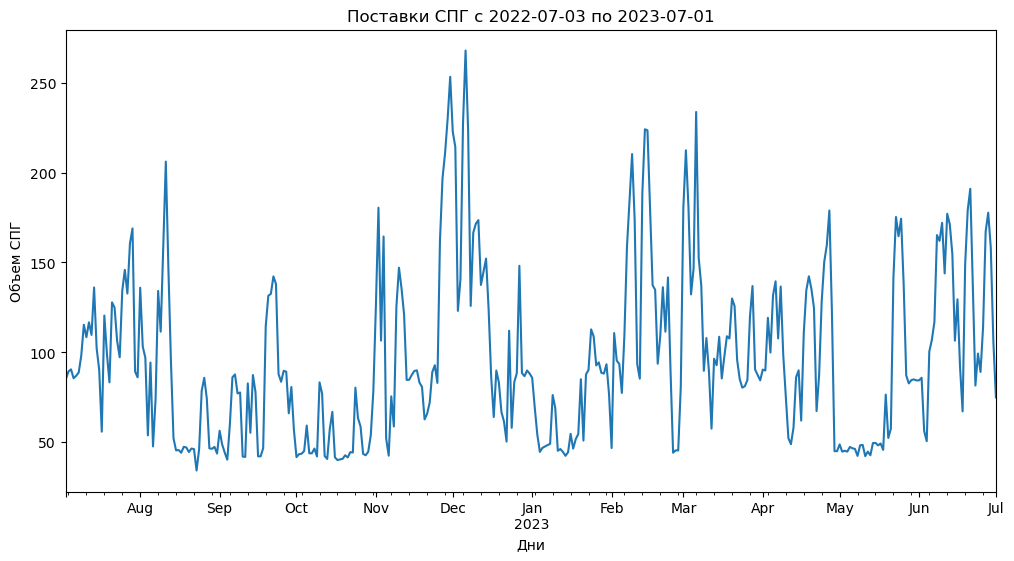

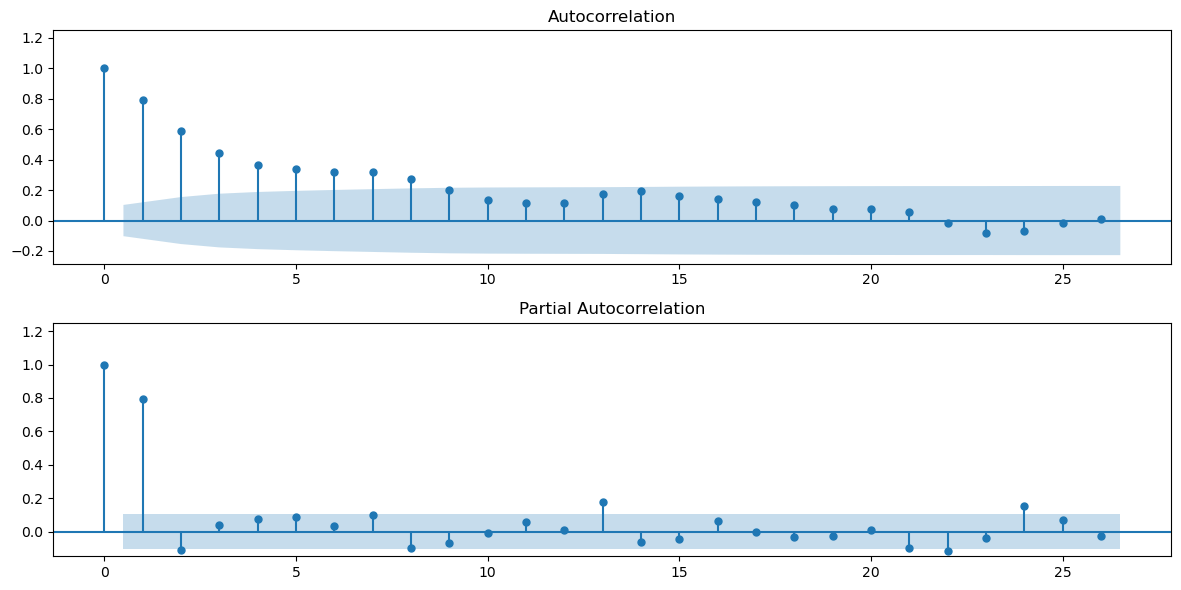

In [533]:
find_start_parameters(df_barcelona)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  328
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 476.814
Date:                Fri, 07 Jul 2023   AIC                           -945.628
Time:                        14:05:22   BIC                           -930.456
Sample:                    07-03-2022   HQIC                          -939.575
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9731      0.015    586.666      0.000       8.943       9.003
ar.L1          0.8068      0.054     14.831      0.000       0.700       0.913
ar.L2         -0.0109      0.050     -0.218      0.8

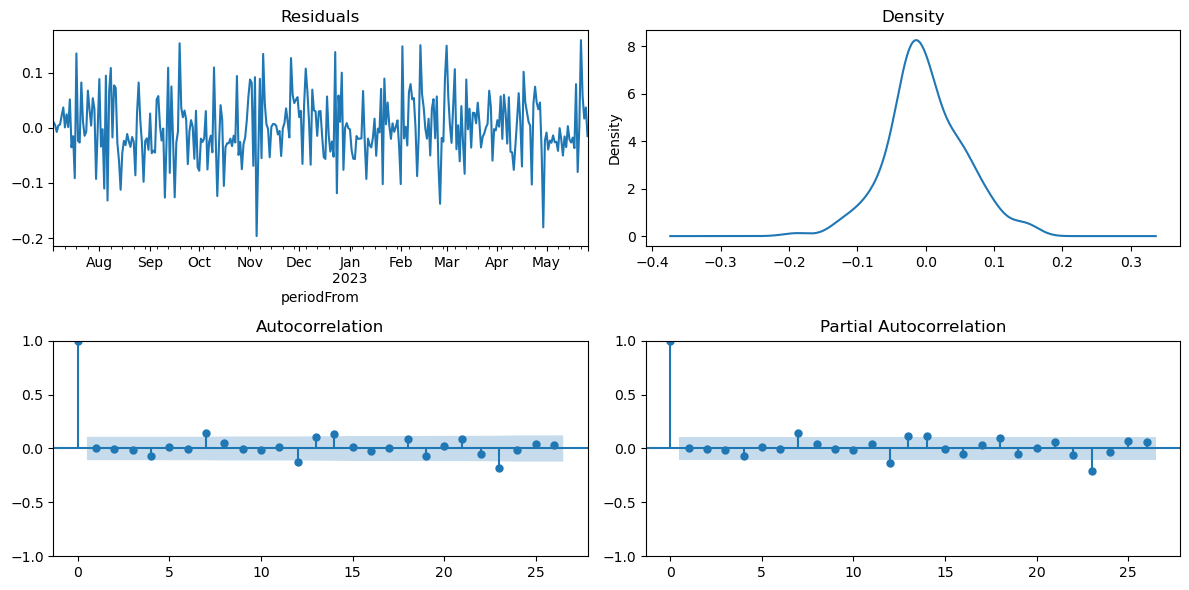

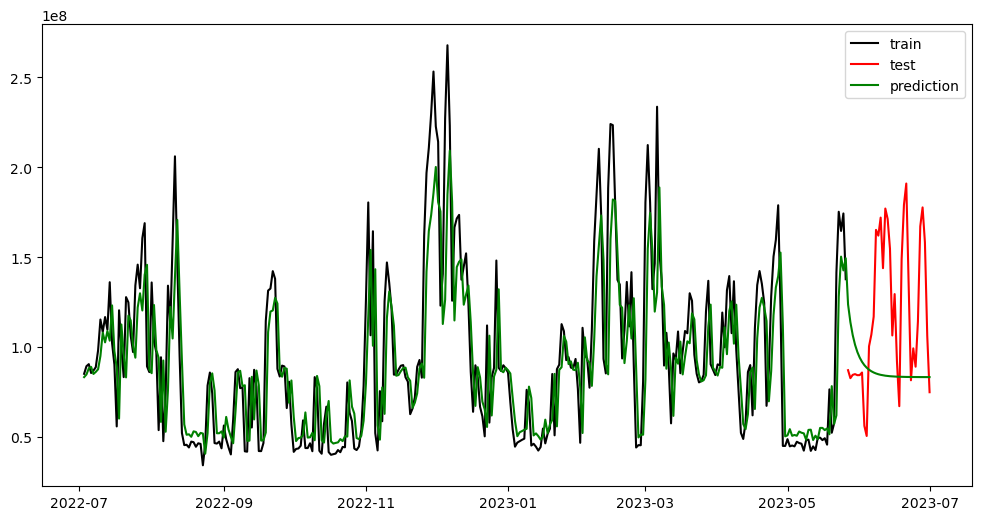

начальная среднеквадратичная ошибка = 0.08915737879668675
лучшее значение среднеквадратичной ошибки = 0.08251440790584433 при параметрах p = 4, d = 0, q = 5
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  328
Model:                 ARIMA(4, 0, 5)   Log Likelihood                 481.233
Date:                Fri, 07 Jul 2023   AIC                           -940.467
Time:                        14:06:59   BIC                           -898.743
Sample:                    07-03-2022   HQIC                          -923.820
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9763      0.024    374.639      0.00

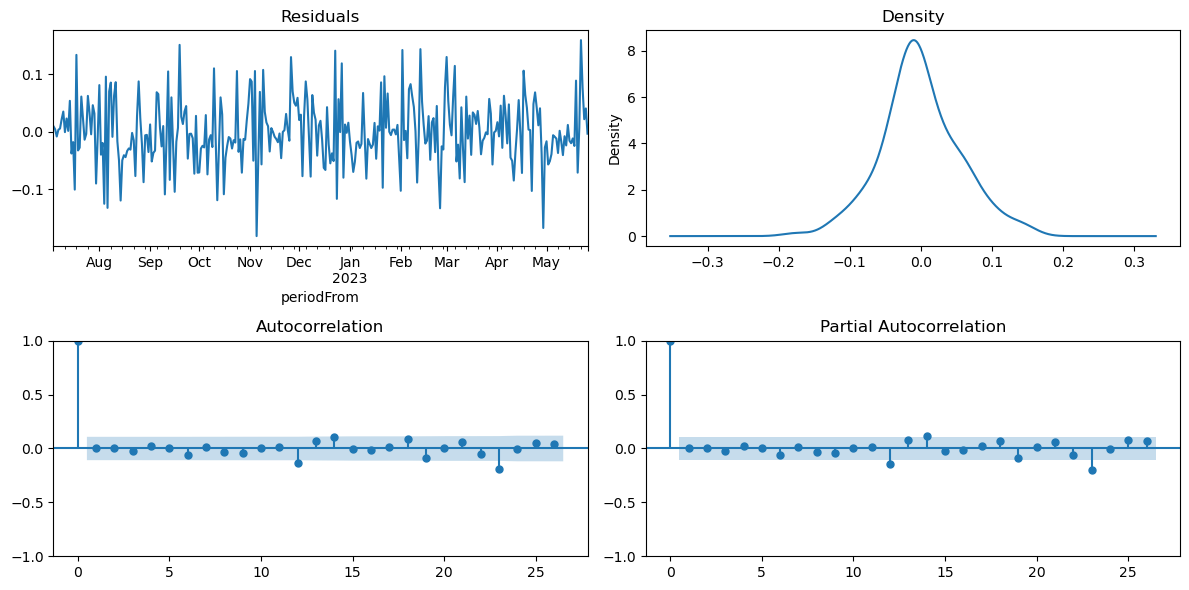

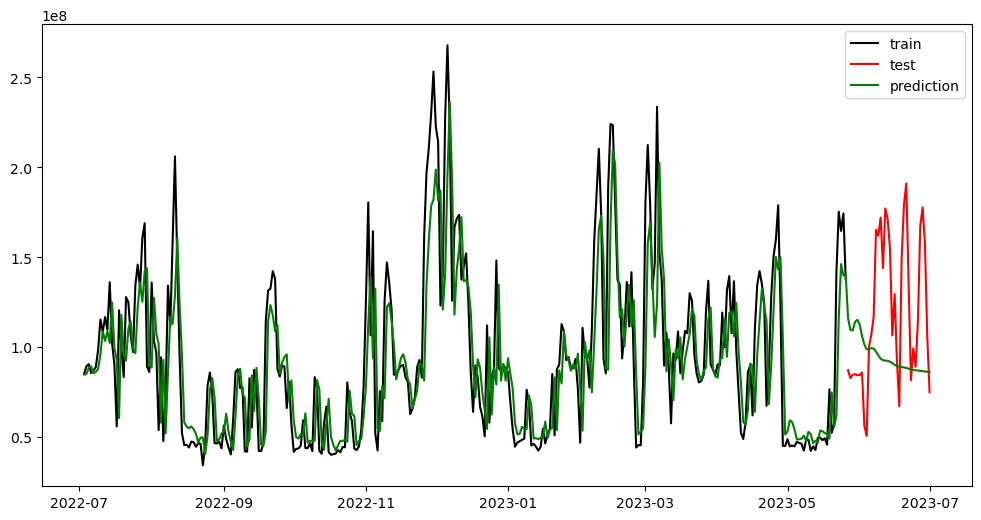

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  364
Model:                 ARIMA(4, 0, 5)   Log Likelihood                 539.110
Date:                Fri, 07 Jul 2023   AIC                          -1056.221
Time:                        14:07:05   BIC                          -1013.352
Sample:                    07-03-2022   HQIC                         -1039.183
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9804      0.021    437.170      0.000       8.940       9.021
ar.L1          1.2073      0.436      2.767      0.006       0.352       2.063
ar.L2         -0.2460      0.793     -0.310      0.7

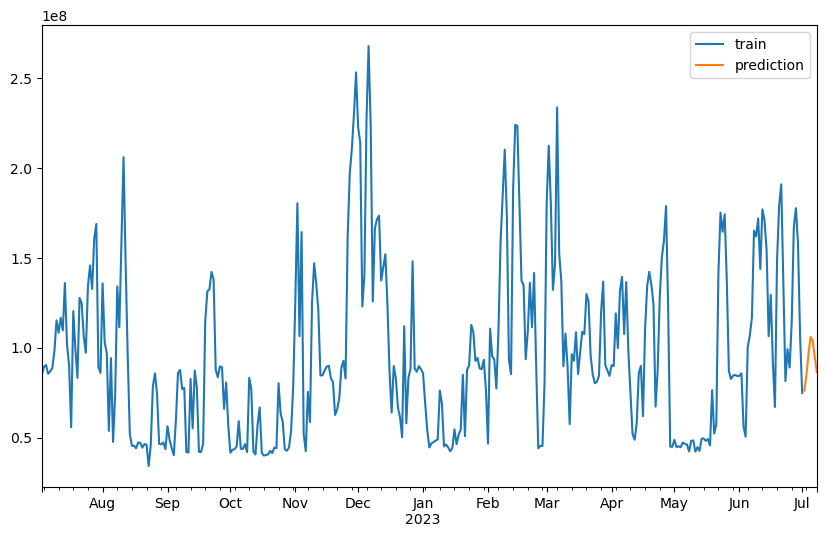

2023-07-02    7.623073e+07
2023-07-03    8.466494e+07
2023-07-04    9.637585e+07
2023-07-05    1.060999e+08
2023-07-06    1.040601e+08
2023-07-07    9.498163e+07
2023-07-08    8.657288e+07
dtype: float64


In [534]:
build_arima_boxcox(df_barcelona, 2, 0, 0)

In [462]:
df_bilbao = data_preprocessing(pd.read_excel('bilbao_lng_spain.xlsx'))
df_bilbao.head()

value
periodFrom           
2022-07-03  170011879
2022-07-04  202770883
2022-07-05  206397016
2022-07-06  201521631
2022-07-07  176170391

порядок дифференцирования = 0


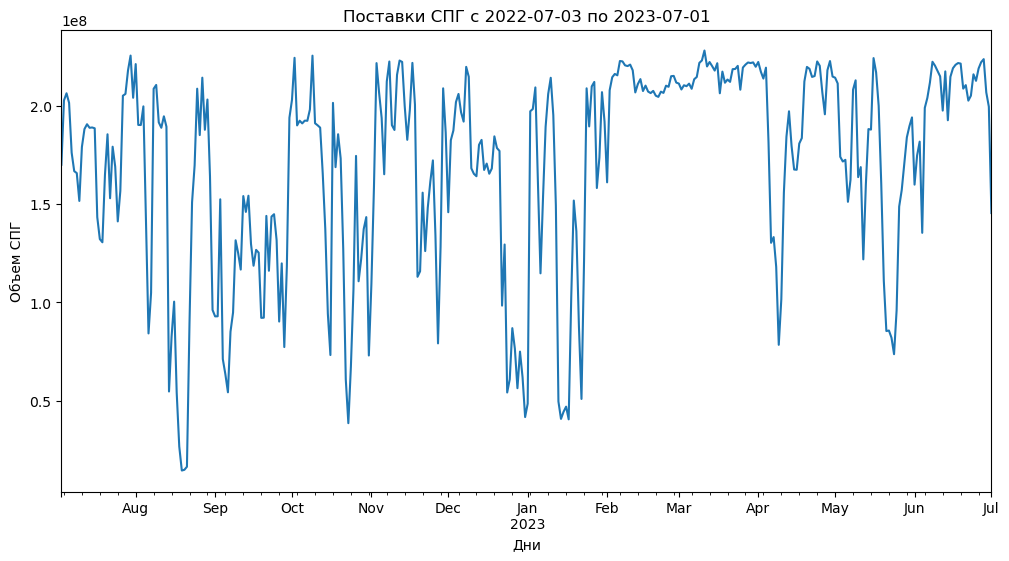

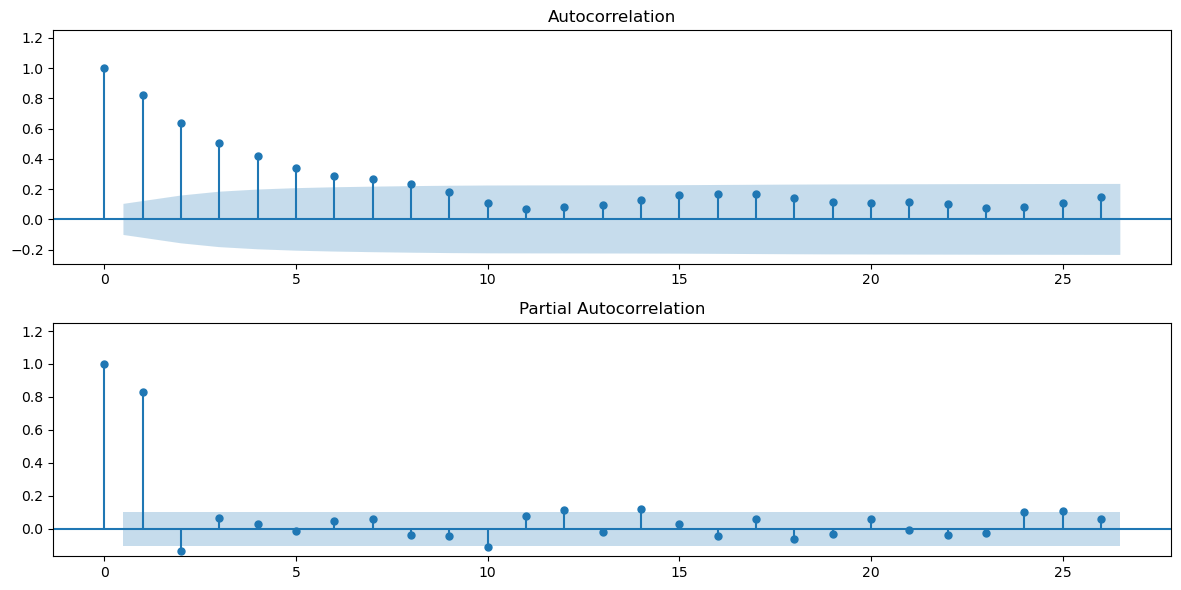

In [463]:
find_start_parameters(df_bilbao)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  328
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -6110.470
Date:                Thu, 06 Jul 2023   AIC                          12228.940
Time:                        14:43:04   BIC                          12244.112
Sample:                    07-03-2022   HQIC                         12234.993
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.659e+08   4.92e-11   3.37e+18      0.000    1.66e+08    1.66e+08
ar.L1          0.9465      0.053     17.994      0.000       0.843       1.050
ar.L2         -0.1532      0.048     -3.223      0.0

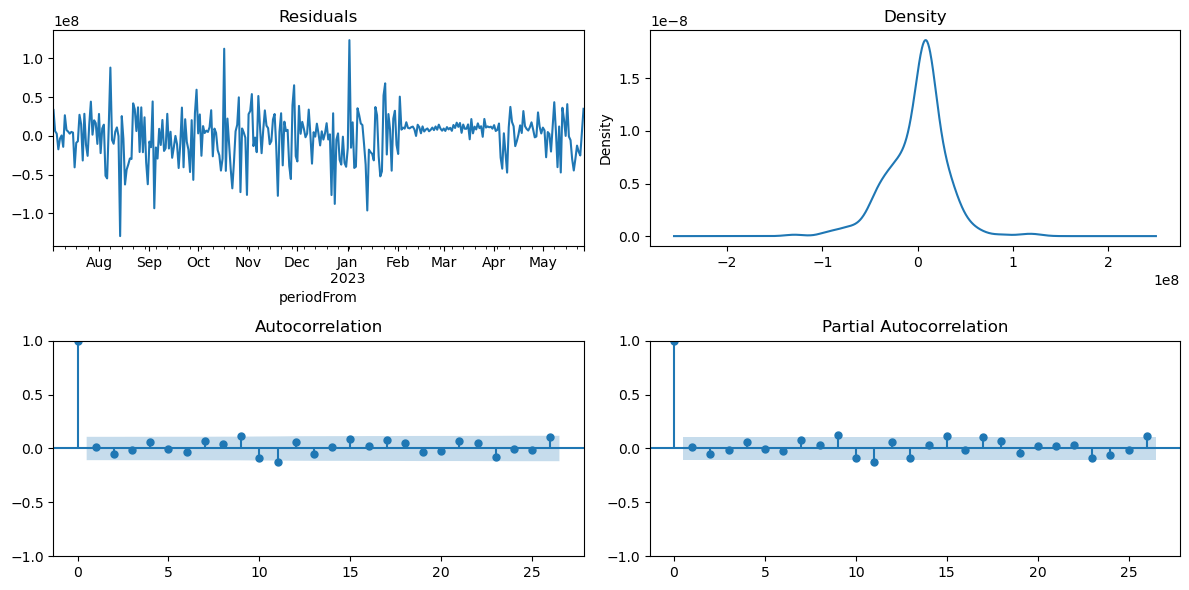

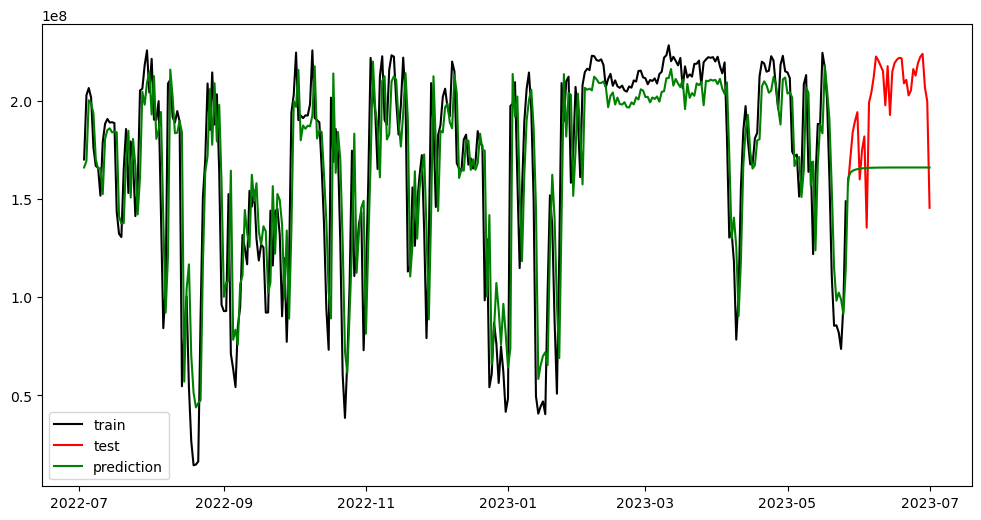

начальная среднеквадратичная ошибка = 48423264.56479526
лучшее значение среднеквадратичной ошибки = 41119326.261240385 при параметрах p = 0, d = 0, q = 6
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  328
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -6115.064
Date:                Thu, 06 Jul 2023   AIC                          12246.129
Time:                        14:44:10   BIC                          12276.473
Sample:                    07-03-2022   HQIC                         12258.235
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.659e+08   1.29e-09   1.29e+17      0.000  

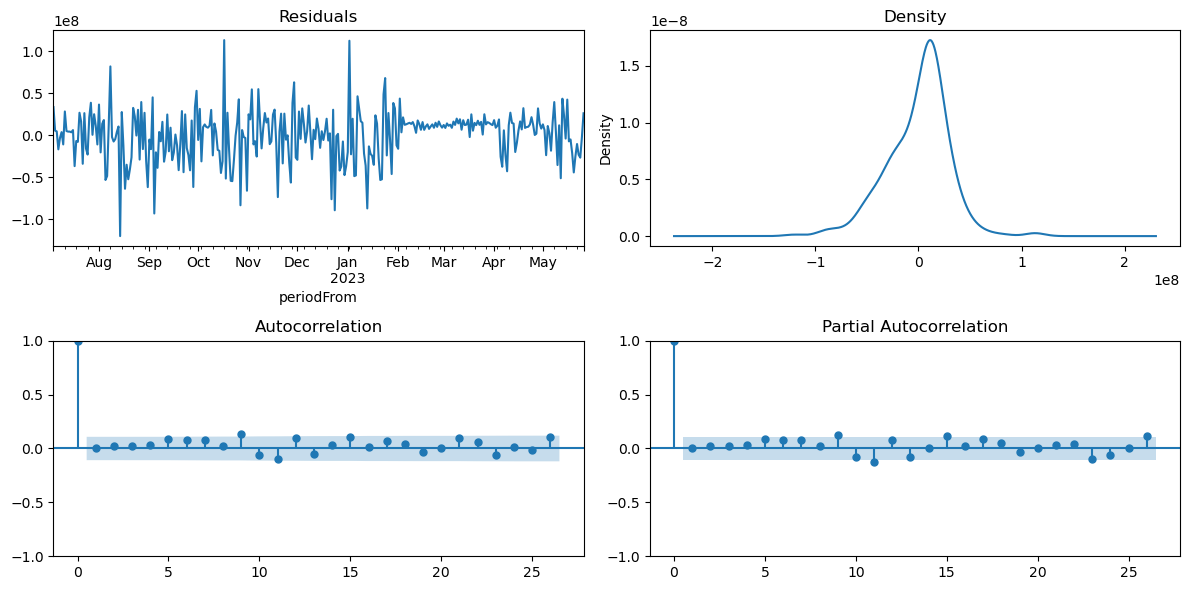

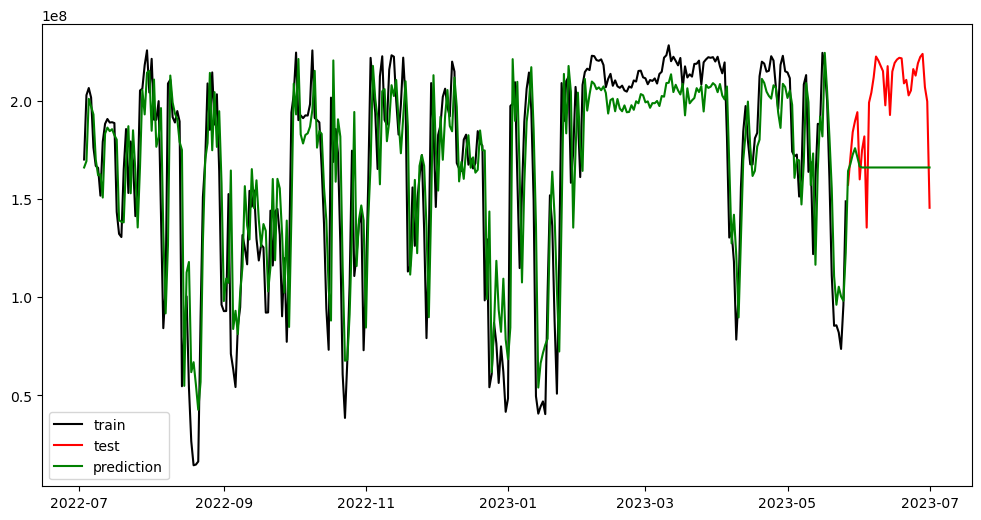

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  364
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -6777.292
Date:                Thu, 06 Jul 2023   AIC                          13570.584
Time:                        14:44:12   BIC                          13601.761
Sample:                    07-03-2022   HQIC                         13582.976
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.694e+08   1.24e-09   1.37e+17      0.000    1.69e+08    1.69e+08
ma.L1          0.9597      0.061     15.631      0.000       0.839       1.080
ma.L2          0.7260      0.084      8.637      0.0

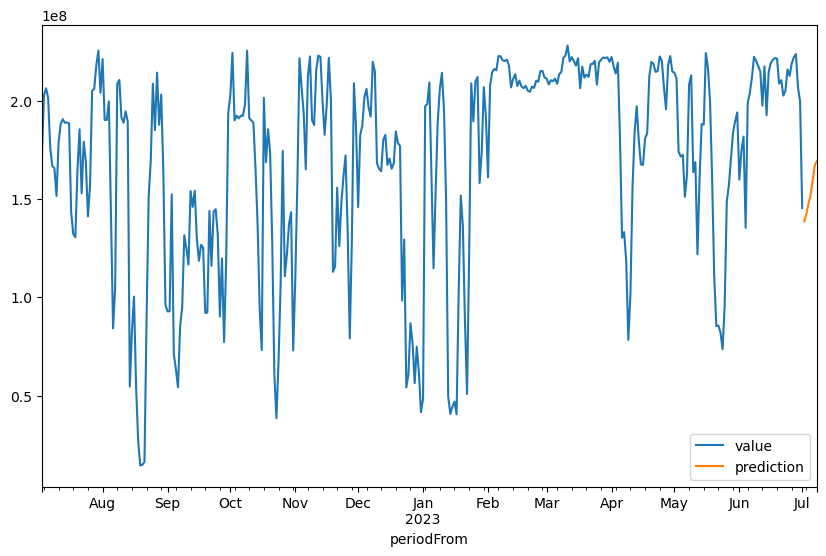

2023-07-02    1.386756e+08
2023-07-03    1.425147e+08
2023-07-04    1.477029e+08
2023-07-05    1.519704e+08
2023-07-06    1.594085e+08
2023-07-07    1.671741e+08
2023-07-08    1.693624e+08
Freq: D, Name: predicted_mean, dtype: float64


In [466]:
build_arima(df_bilbao, 2, 0, 0)

In [288]:
df_croatia = data_preprocessing(pd.read_excel('croatia_lng.xlsx'))
df_croatia.head()

value
periodFrom          
2022-07-03  83568335
2022-07-04  83576706
2022-07-05  85041103
2022-07-06  85910133
2022-07-07  84744834

порядок дифференцирования = 0


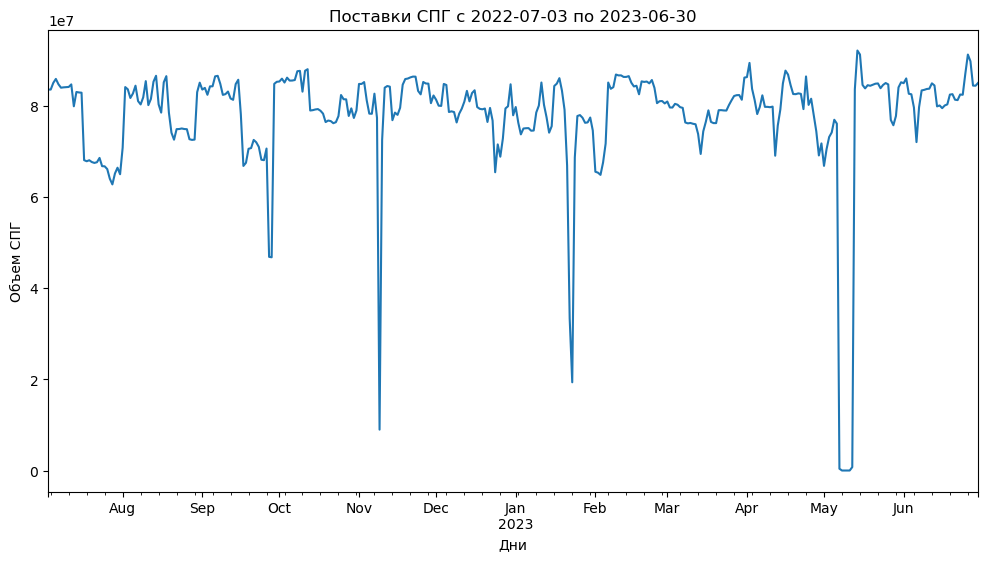

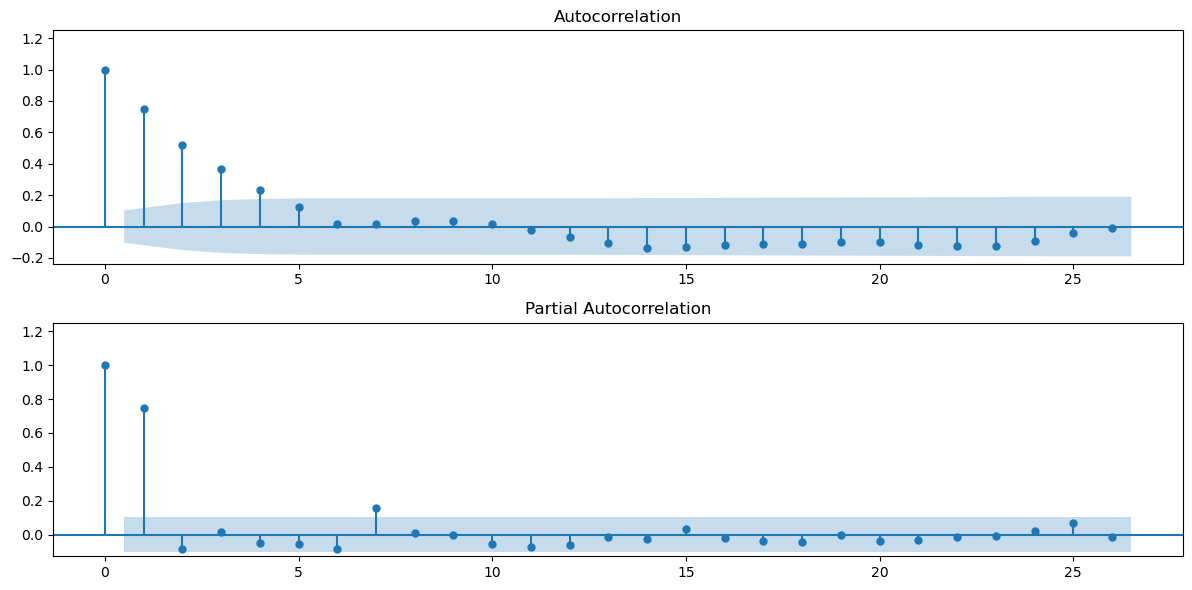

In [289]:
find_start_parameters(df_croatia)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  327
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5702.435
Date:                Wed, 05 Jul 2023   AIC                          11410.870
Time:                        16:39:30   BIC                          11422.240
Sample:                    07-03-2022   HQIC                         11415.406
                         - 05-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.733e+07   4.32e-11   1.79e+18      0.000    7.73e+07    7.73e+07
ar.L1          0.7419      0.011     64.767      0.000       0.719       0.764
sigma2      8.213e+13   3.28e-17    2.5e+30      0.0

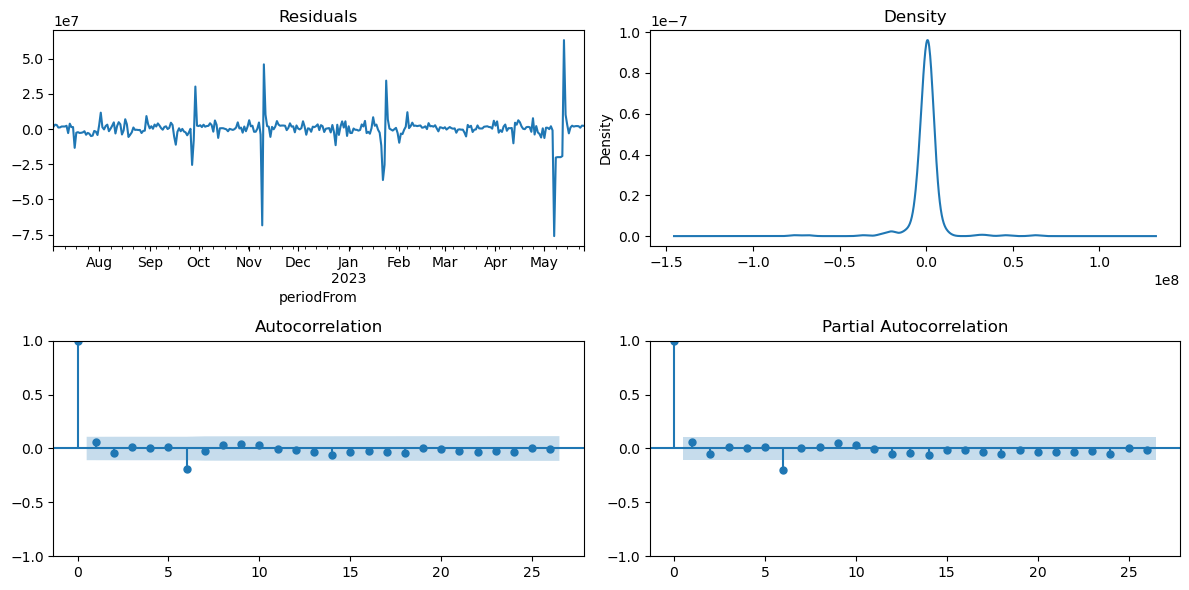

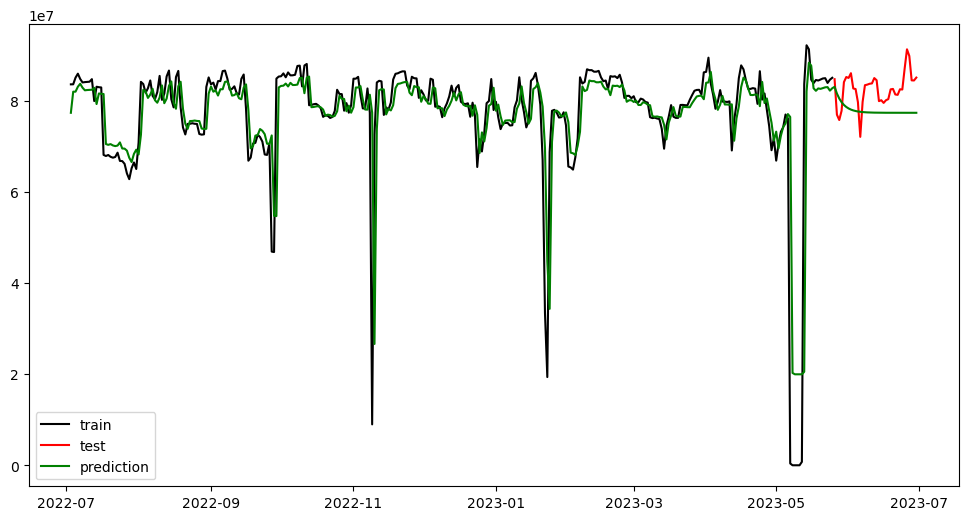

начальная среднеквадратичная ошибка = 48423264.56479526
лучшее значение среднеквадратичной ошибки = 4958712.450528894 при параметрах p = 7, d = 0, q = 7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  327
Model:                 ARIMA(7, 0, 7)   Log Likelihood               -5693.551
Date:                Wed, 05 Jul 2023   AIC                          11419.101
Time:                        16:40:28   BIC                          11479.740
Sample:                    07-03-2022   HQIC                         11443.297
                         - 05-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.733e+07   1.24e-07   6.25e+14      0.000   

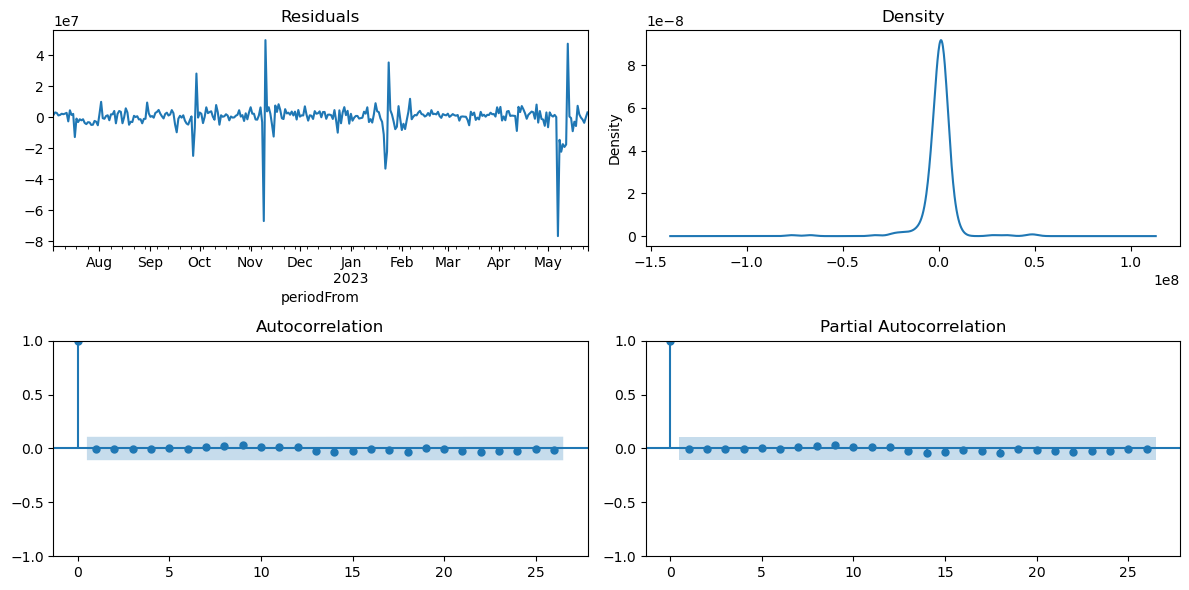

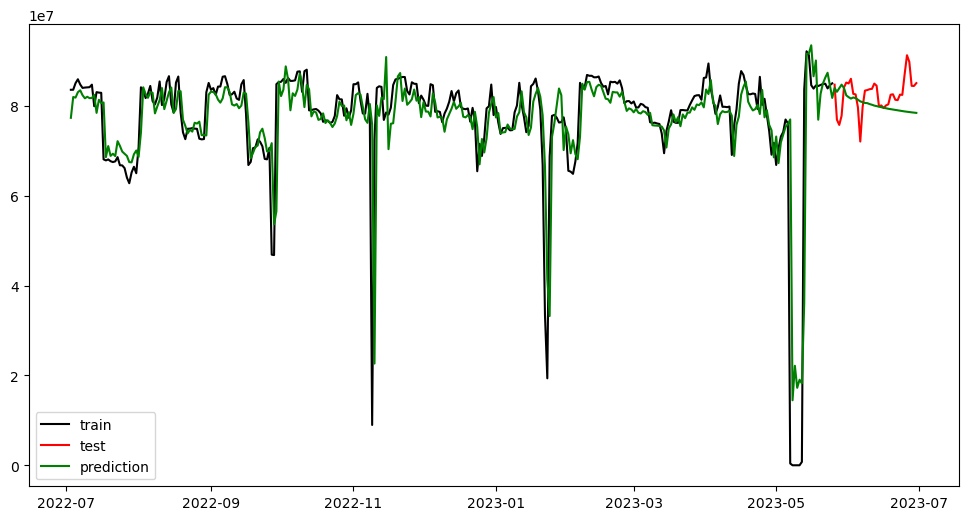

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  363
Model:                 ARIMA(7, 0, 7)   Log Likelihood               -6302.690
Date:                Wed, 05 Jul 2023   AIC                          12637.381
Time:                        16:40:33   BIC                          12699.691
Sample:                    07-03-2022   HQIC                         12662.149
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.784e+07   9.86e-07   7.89e+13      0.000    7.78e+07    7.78e+07
ar.L1          1.0919      3.828      0.285      0.775      -6.410       8.594
ar.L2         -0.1942      4.077     -0.048      0.9

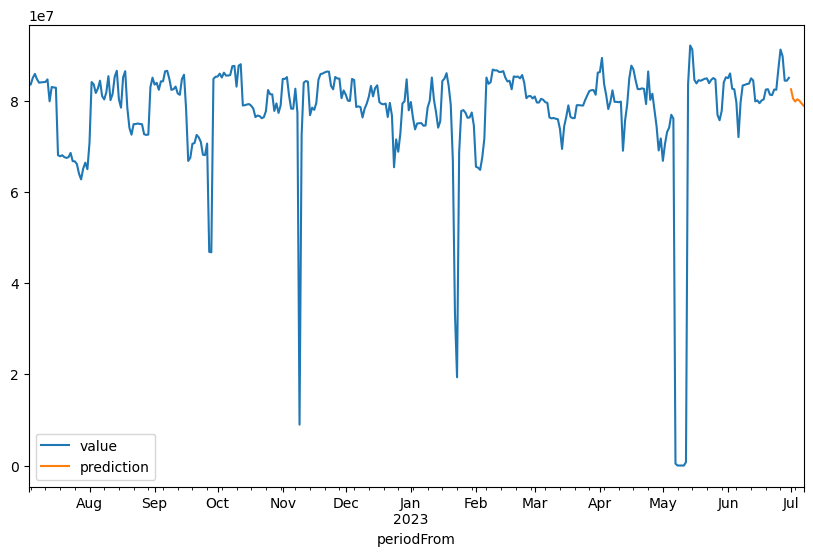

2023-07-01    8.254321e+07
2023-07-02    8.048807e+07
2023-07-03    7.985495e+07
2023-07-04    8.035334e+07
2023-07-05    8.003744e+07
2023-07-06    7.944446e+07
2023-07-07    7.895422e+07
Freq: D, Name: predicted_mean, dtype: float64


In [290]:
build_arima(df_croatia, 1, 0, 0)

In [291]:
df_netherlands = data_preprocessing(pd.read_excel('gate_terminal_netherlands.xlsx'))
df_netherlands.head()

value
periodFrom             
2022-07-03  490152160.6
2022-07-04  488663325.3
2022-07-05  490504934.2
2022-07-06  495124242.8
2022-07-07  496042674.7

In [298]:
model = ARIMA(df_netherlands, order=(1,0,1))
model = model.fit()
pred = model.predict(start=len(df_netherlands), end=len(df_netherlands)+6)
pred

2023-07-03    4.240209e+08
2023-07-04    4.475851e+08
2023-07-05    4.620353e+08
2023-07-06    4.708964e+08
2023-07-07    4.763303e+08
2023-07-08    4.796625e+08
2023-07-09    4.817058e+08
Freq: D, Name: predicted_mean, dtype: float64

In [303]:
pred['2023-07-10'] = -5
pred

2023-07-03    4.240209e+08
2023-07-04    4.475851e+08
2023-07-05    4.620353e+08
2023-07-06    4.708964e+08
2023-07-07    4.763303e+08
2023-07-08    4.796625e+08
2023-07-09    4.817058e+08
2023-07-10   -5.000000e+00
Freq: D, Name: predicted_mean, dtype: float64

In [304]:
pred = pred.apply(lambda x: 0 if x < 0 else x)
pred

2023-07-03    4.240209e+08
2023-07-04    4.475851e+08
2023-07-05    4.620353e+08
2023-07-06    4.708964e+08
2023-07-07    4.763303e+08
2023-07-08    4.796625e+08
2023-07-09    4.817058e+08
2023-07-10    0.000000e+00
Freq: D, Name: predicted_mean, dtype: float64

порядок дифференцирования = 0


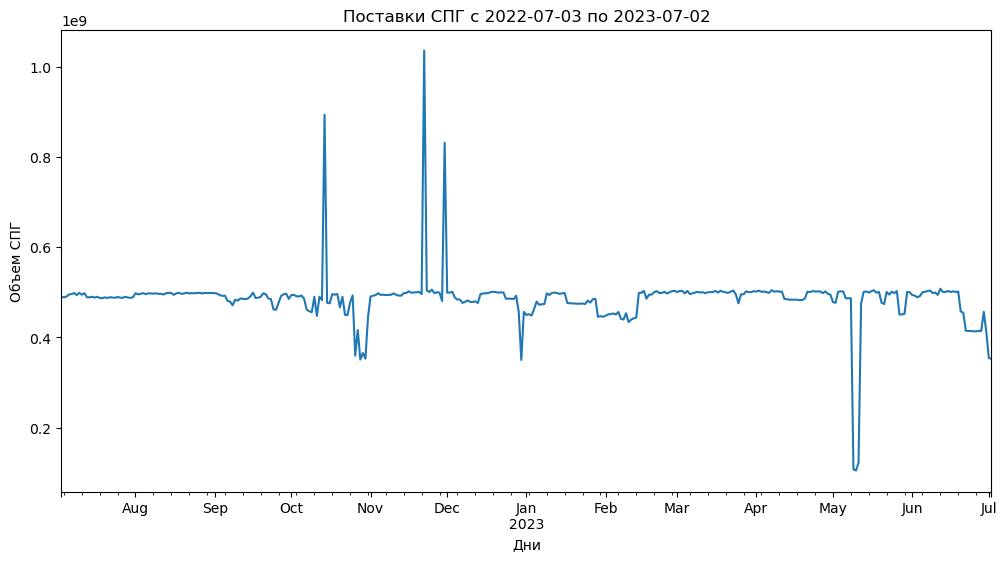

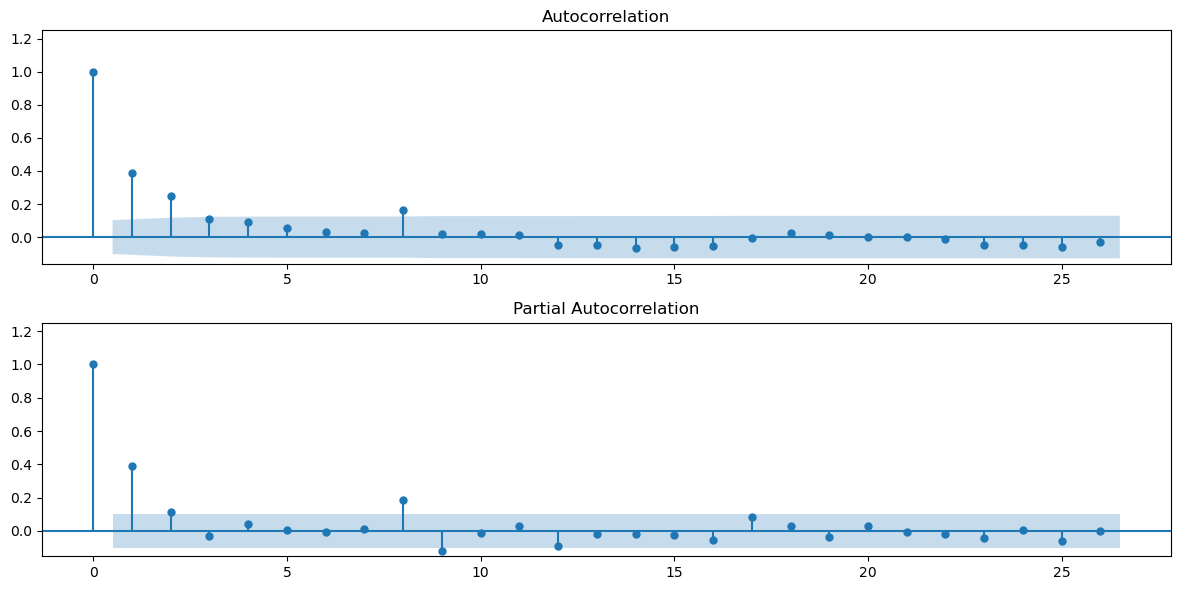

In [292]:
find_start_parameters(df_netherlands)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  329
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6335.094
Date:                Wed, 05 Jul 2023   AIC                          12676.189
Time:                        16:47:22   BIC                          12687.577
Sample:                    07-03-2022   HQIC                         12680.732
                         - 05-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.87e+08   6.18e-12   7.88e+19      0.000    4.87e+08    4.87e+08
ar.L1          0.3572      0.017     20.986      0.000       0.324       0.391
sigma2      3.118e+15   4.64e-19   6.72e+33      0.0

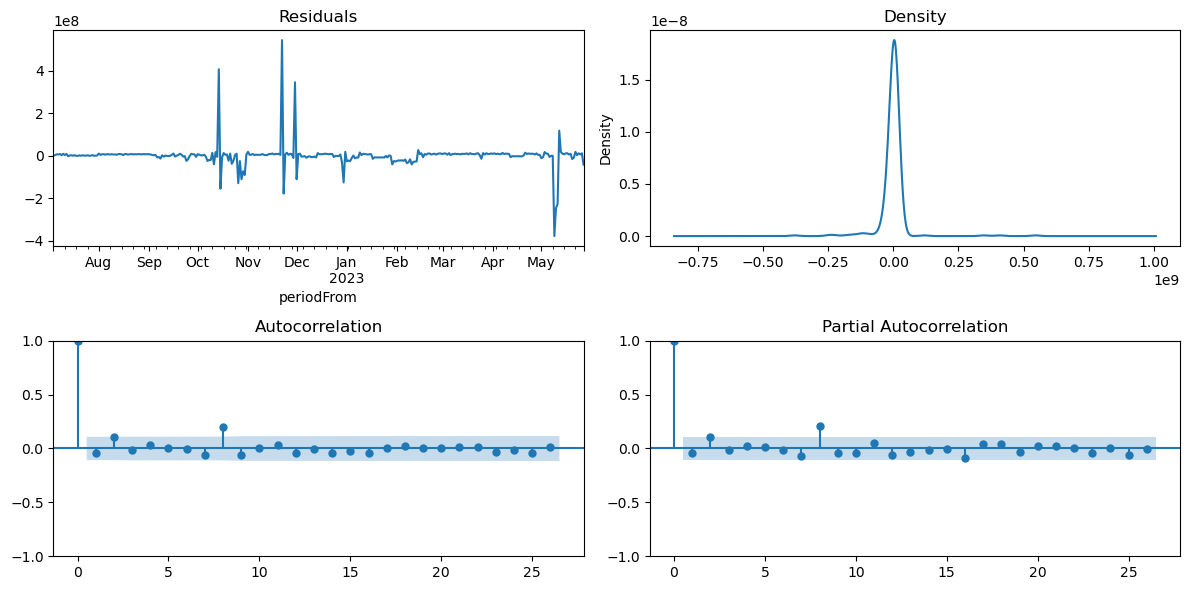

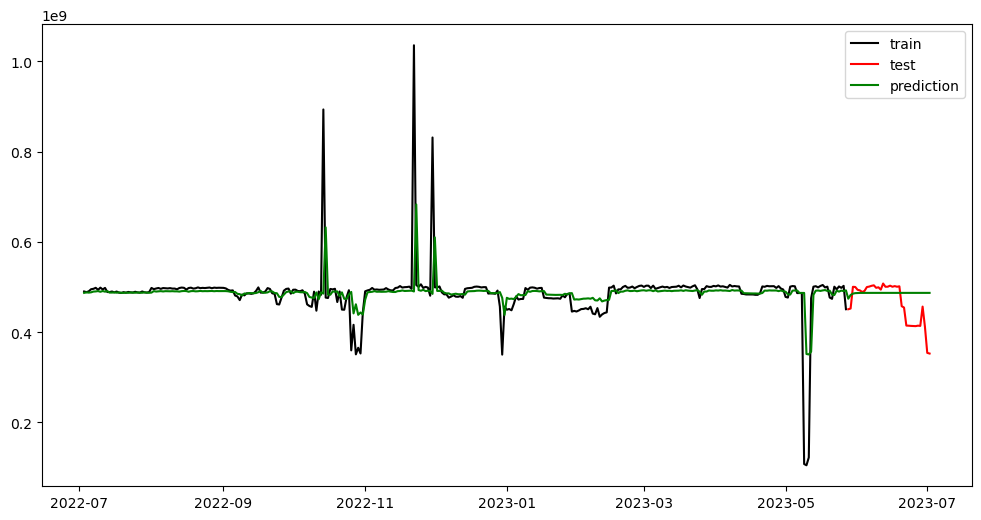

начальная среднеквадратичная ошибка = 48423264.56479526
лучшее значение среднеквадратичной ошибки = 48773777.44776787 при параметрах p = 6, d = 0, q = 5
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  329
Model:                 ARIMA(6, 0, 5)   Log Likelihood               -6326.172
Date:                Wed, 05 Jul 2023   AIC                          12678.343
Time:                        16:48:29   BIC                          12727.692
Sample:                    07-03-2022   HQIC                         12698.030
                         - 05-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.87e+08   2.52e-07   1.94e+15      0.000   

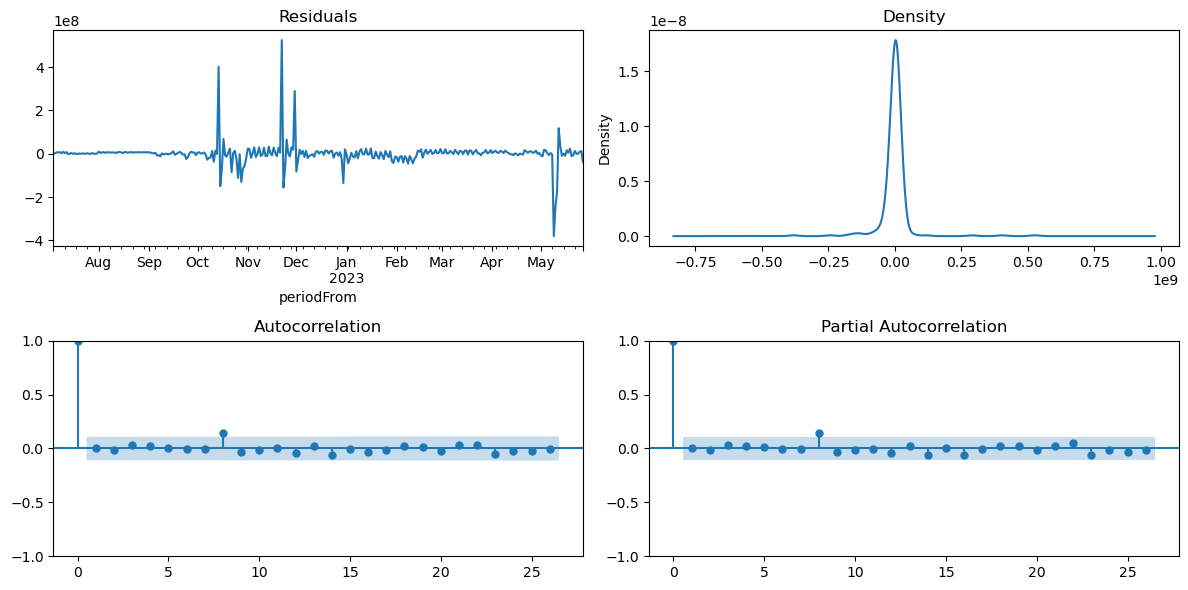

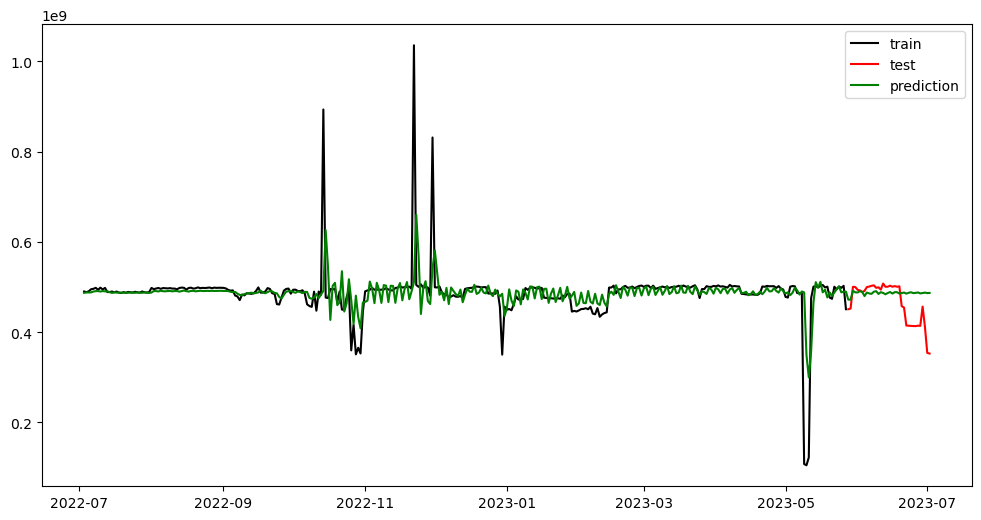

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  365
Model:                 ARIMA(6, 0, 5)   Log Likelihood               -7005.705
Date:                Wed, 05 Jul 2023   AIC                          14037.410
Time:                        16:48:33   BIC                          14088.109
Sample:                    07-03-2022   HQIC                         14057.558
                         - 07-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.849e+08   2.06e-07   2.35e+15      0.000    4.85e+08    4.85e+08
ar.L1          0.1937      0.919      0.211      0.833      -1.608       1.996
ar.L2          0.4914      0.664      0.740      0.4

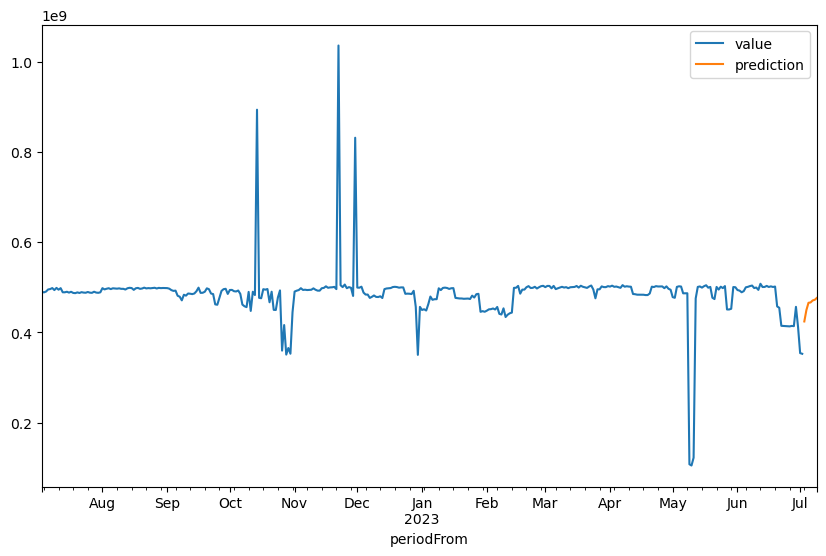

2023-07-03    4.243173e+08
2023-07-04    4.495551e+08
2023-07-05    4.656136e+08
2023-07-06    4.664120e+08
2023-07-07    4.708099e+08
2023-07-08    4.722502e+08
2023-07-09    4.763476e+08
Freq: D, Name: predicted_mean, dtype: float64


In [294]:
build_arima(df_netherlands, 1, 0, 0)

In [295]:
df_britain = data_preprocessing(pd.read_excel('isle_of_grain_britain.xlsx'))
df_britain.head()

value
periodFrom           
2022-07-03        0.0
2022-07-04        0.0
2022-07-05  2299650.0
2022-07-06        0.0
2022-07-07        0.0

порядок дифференцирования = 1


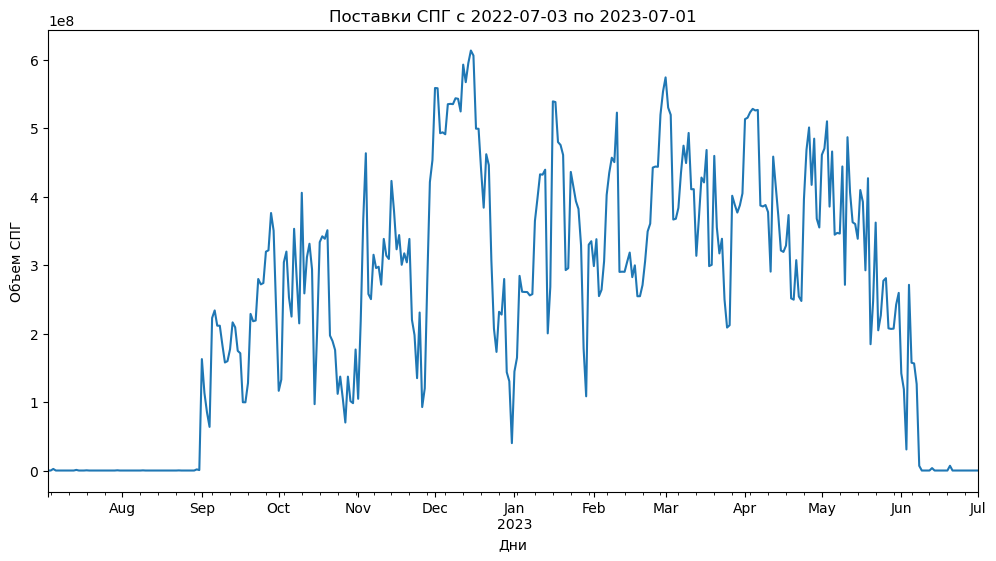

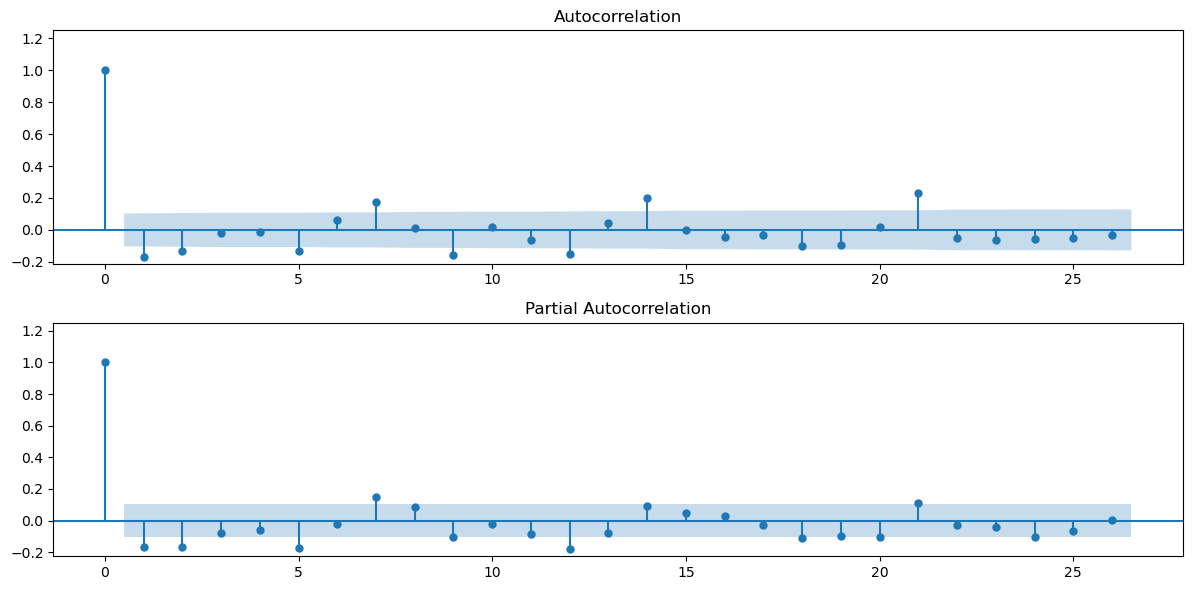

In [296]:
find_start_parameters(df_britain)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  328
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6366.199
Date:                Wed, 05 Jul 2023   AIC                          12742.398
Time:                        21:08:34   BIC                          12761.348
Sample:                    07-03-2022   HQIC                         12749.960
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1300      0.600     -0.217      0.828      -1.306       1.046
ar.L2          0.6566      0.434      1.513      0.130      -0.194       1.507
ma.L1         -0.0746      0.617     -0.121      0.9

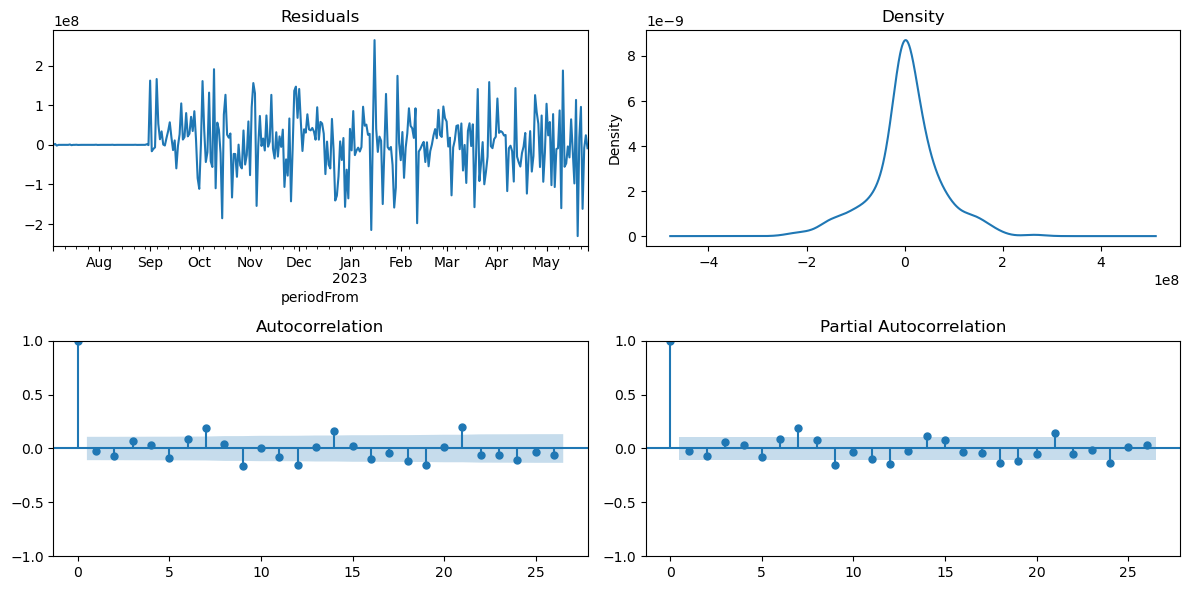

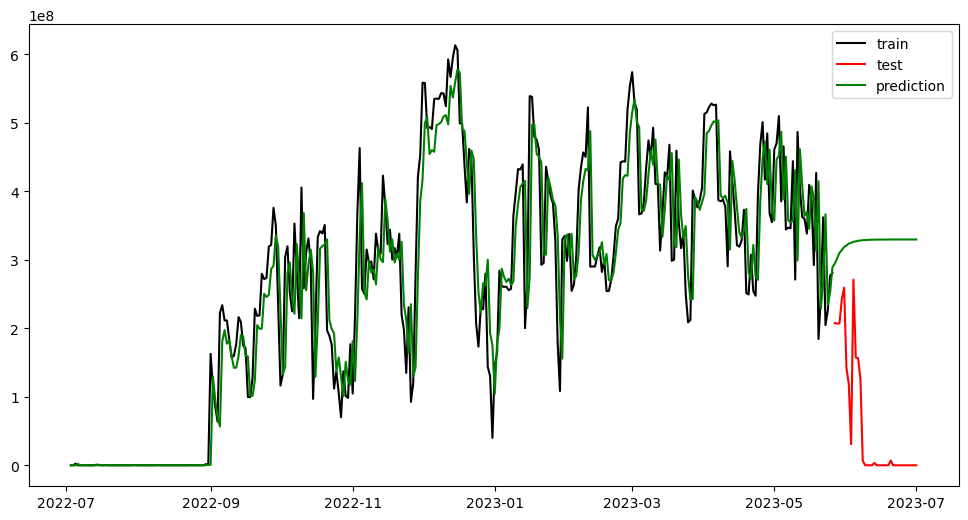

начальная среднеквадратичная ошибка = 48423264.56479526
лучшее значение среднеквадратичной ошибки = 215220732.27721748 при параметрах p = 7, d = 1, q = 1
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  328
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -6359.396
Date:                Wed, 05 Jul 2023   AIC                          12736.792
Time:                        21:09:49   BIC                          12770.901
Sample:                    07-03-2022   HQIC                         12750.402
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0112      0.394     -0.028      0.977  

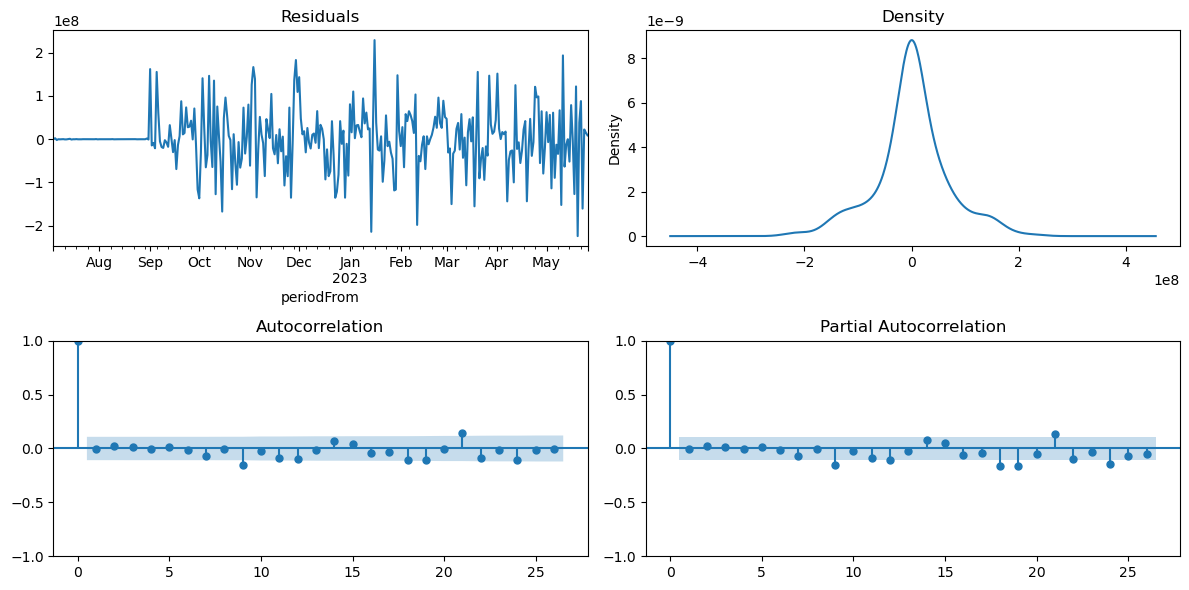

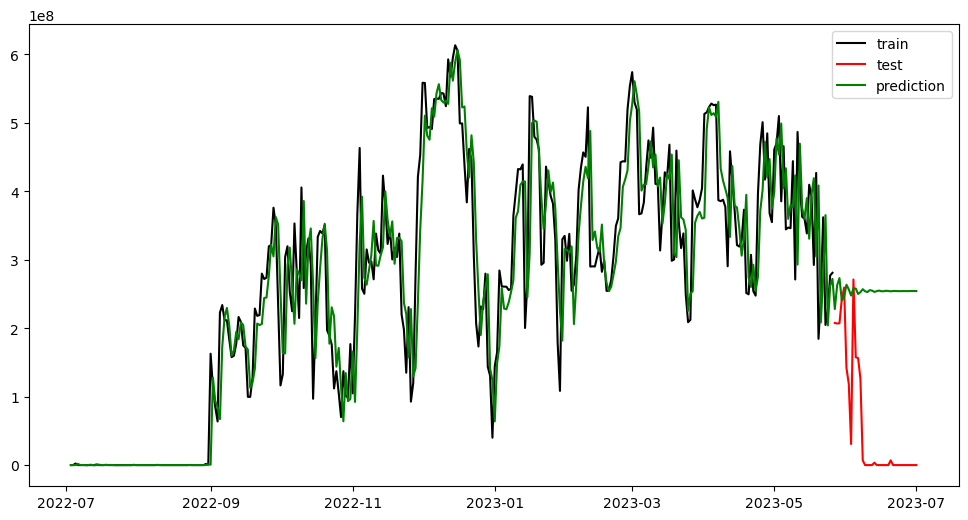

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  364
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -7052.939
Date:                Wed, 05 Jul 2023   AIC                          14123.877
Time:                        21:09:51   BIC                          14158.927
Sample:                    07-03-2022   HQIC                         14137.809
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0218      0.367     -0.059      0.953      -0.741       0.698
ar.L2         -0.1368      0.092     -1.481      0.139      -0.318       0.044
ar.L3         -0.0681      0.085     -0.805      0.4

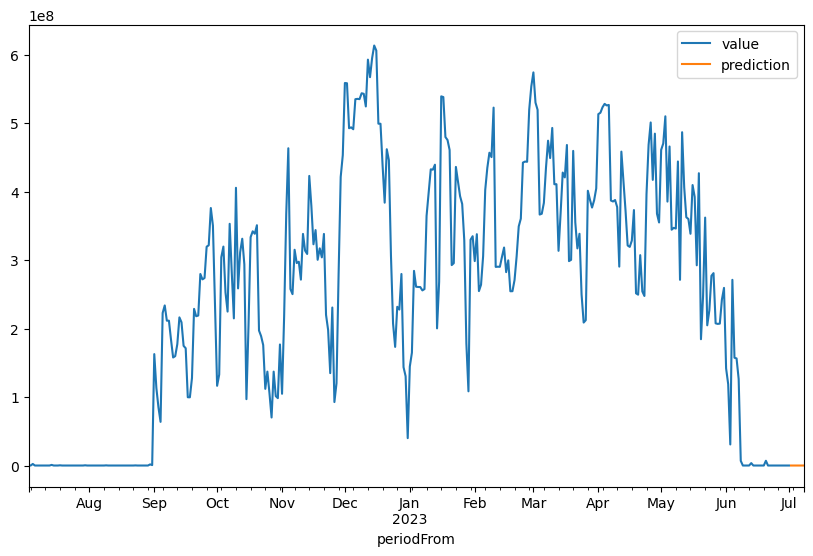

2023-07-02    0
2023-07-03    0
2023-07-04    0
2023-07-05    0
2023-07-06    0
2023-07-07    0
2023-07-08    0
Freq: D, Name: predicted_mean, dtype: int64


In [306]:
build_arima(df_britain, 2, 1, 2)

In [307]:
df_lithuania = data_preprocessing(pd.read_excel('klaipeda_lng_lithunia.xlsx'))
df_lithuania.head()

value
periodFrom           
2022-07-03  110559462
2022-07-04  112727760
2022-07-05  114412367
2022-07-06   96759309
2022-07-07  104847979

порядок дифференцирования = 0


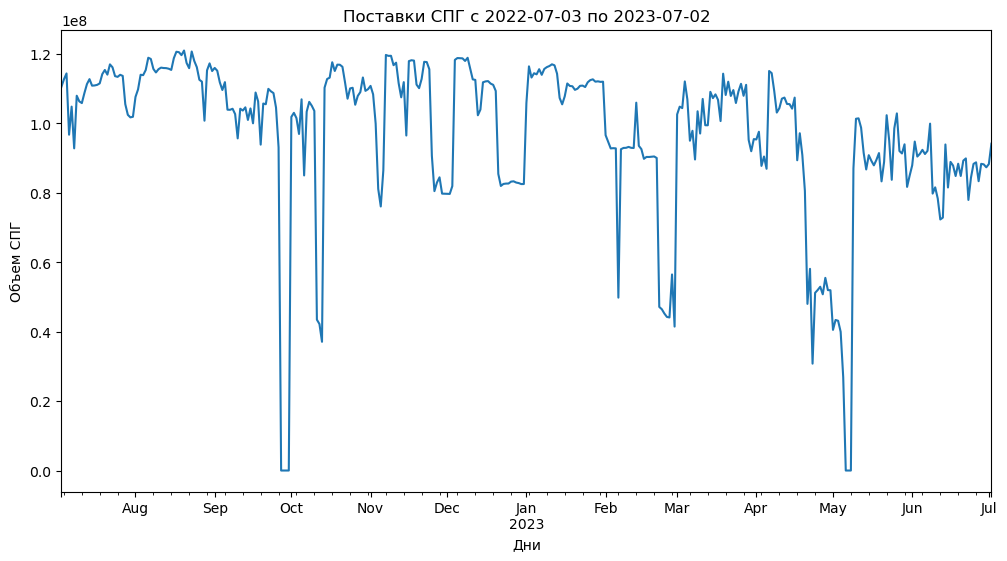

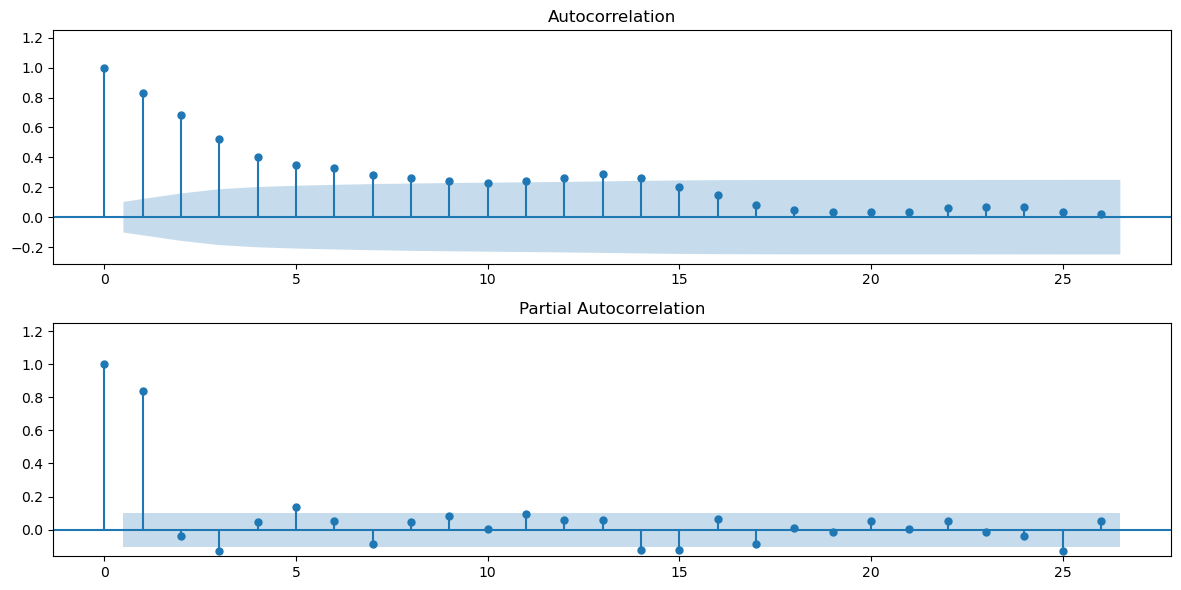

In [308]:
find_start_parameters(df_lithuania)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  329
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5862.451
Date:                Wed, 05 Jul 2023   AIC                          11730.903
Time:                        21:18:50   BIC                          11742.291
Sample:                    07-03-2022   HQIC                         11735.446
                         - 05-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.806e+07   2.71e-11   3.62e+18      0.000    9.81e+07    9.81e+07
ar.L1          0.8319      0.013     63.027      0.000       0.806       0.858
sigma2      1.755e+14   2.29e-17   7.67e+30      0.0

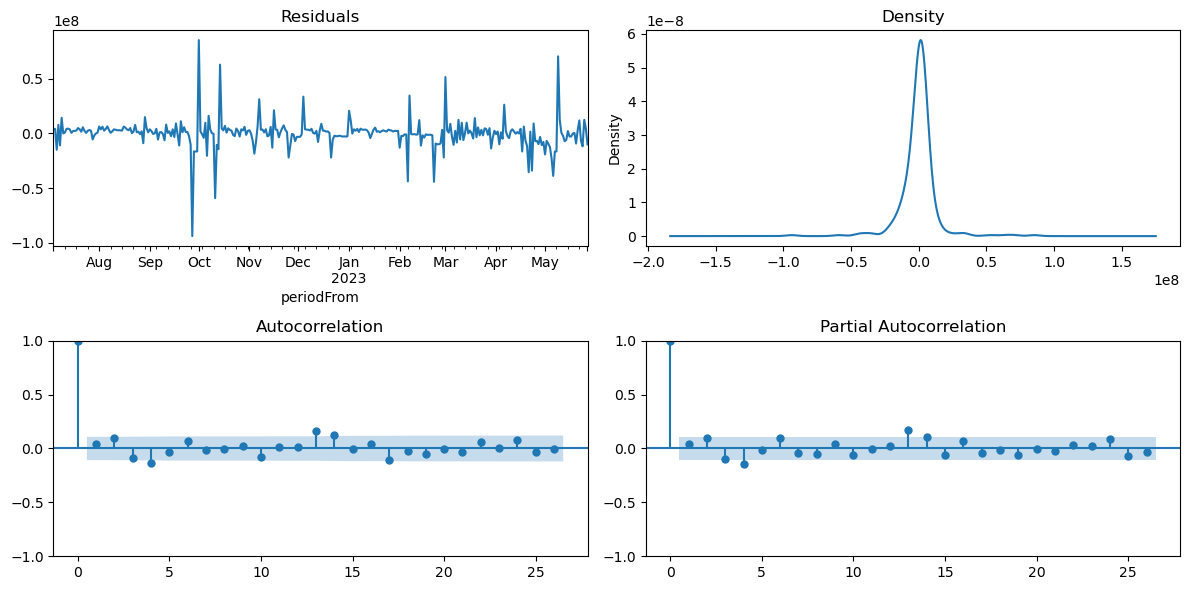

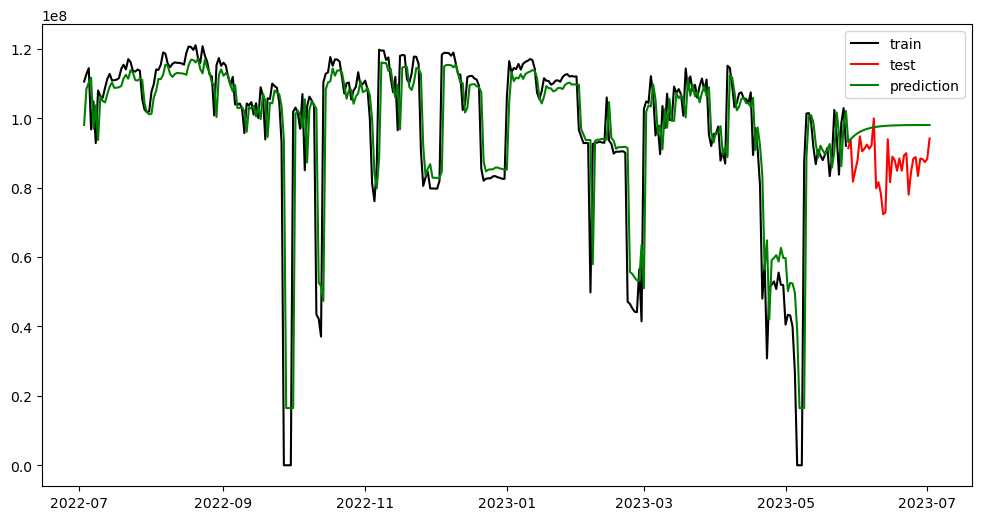

начальная среднеквадратичная ошибка = 48423264.56479526
лучшее значение среднеквадратичной ошибки = 7751691.389703571 при параметрах p = 5, d = 0, q = 3
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  329
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -5852.541
Date:                Wed, 05 Jul 2023   AIC                          11725.081
Time:                        21:19:59   BIC                          11763.042
Sample:                    07-03-2022   HQIC                         11740.225
                         - 05-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.806e+07   3.96e-09   2.48e+16      0.000   

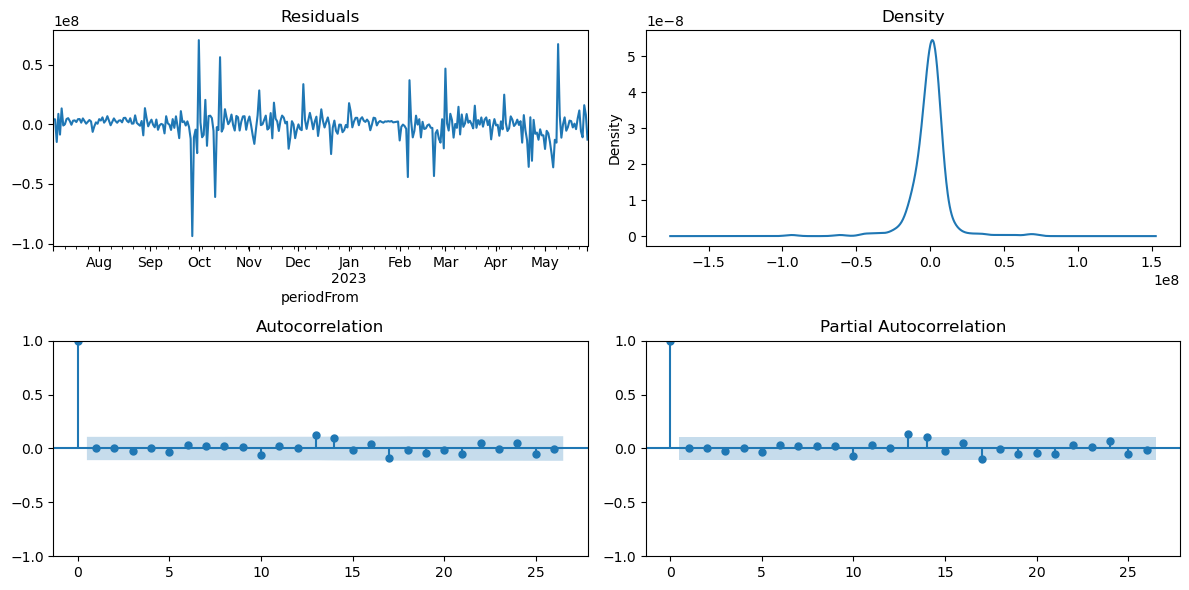

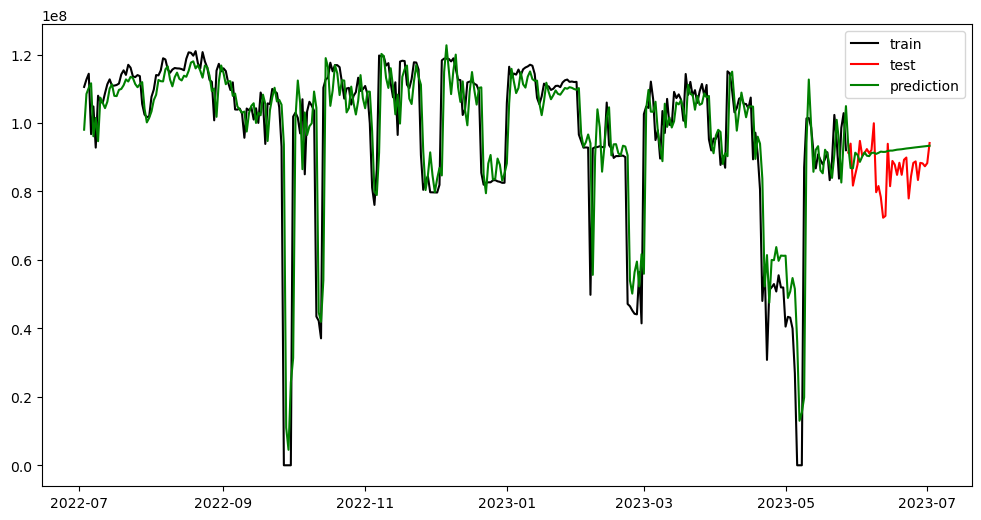

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  365
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -6480.120
Date:                Wed, 05 Jul 2023   AIC                          12980.240
Time:                        21:20:02   BIC                          13019.239
Sample:                    07-03-2022   HQIC                         12995.738
                         - 07-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.698e+07   3.93e-08   2.47e+15      0.000     9.7e+07     9.7e+07
ar.L1         -0.1472      0.769     -0.191      0.848      -1.654       1.360
ar.L2         -0.1051      0.403     -0.261      0.7

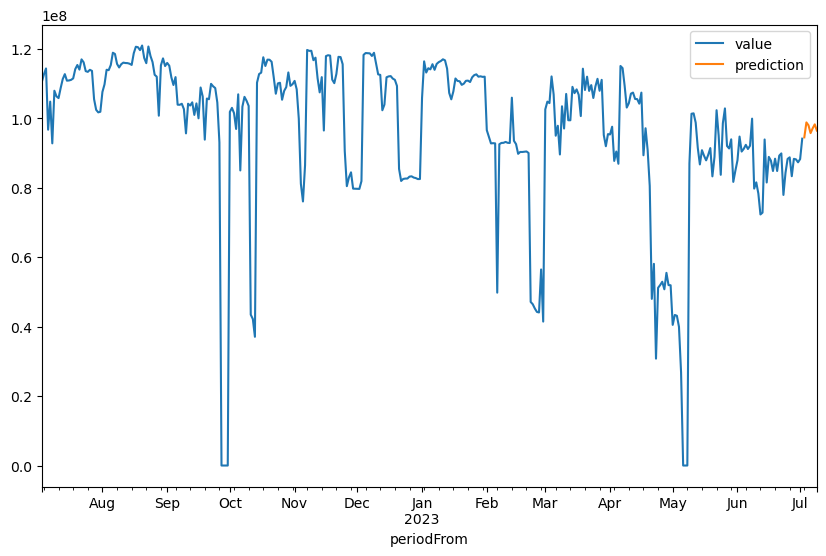

2023-07-03    9.455291e+07
2023-07-04    9.885877e+07
2023-07-05    9.802659e+07
2023-07-06    9.577828e+07
2023-07-07    9.716869e+07
2023-07-08    9.830110e+07
2023-07-09    9.651042e+07
Freq: D, Name: predicted_mean, dtype: float64


In [309]:
build_arima(df_lithuania, 1, 0, 0)

In [310]:
df_livorno = data_preprocessing(pd.read_excel('livorno_lng_italy.xlsx'))
df_livorno.head()

value
periodFrom           
2022-07-03  154998688
2022-07-04  150817248
2022-07-05  150802070
2022-07-06  150798588
2022-07-07  146137534

порядок дифференцирования = 0


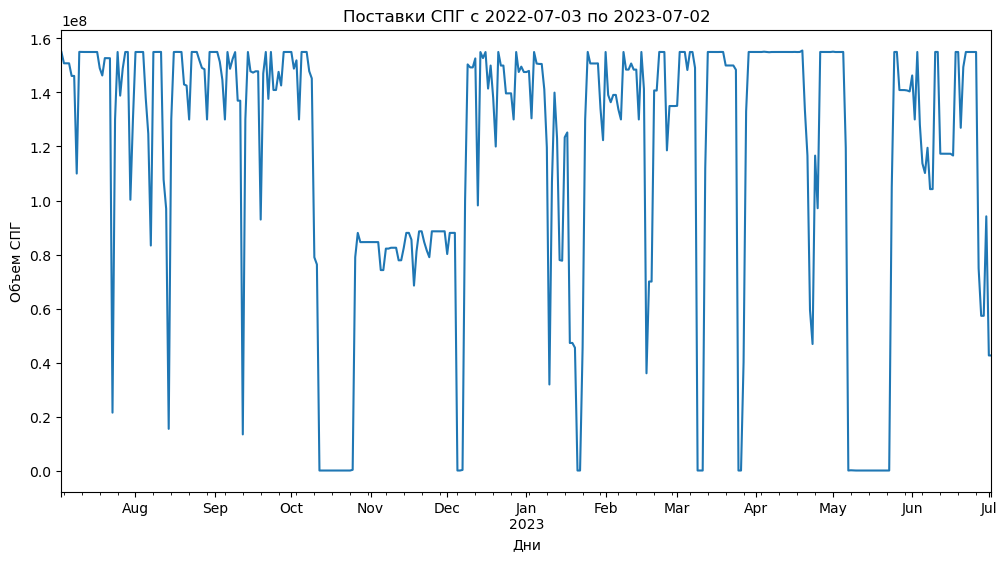

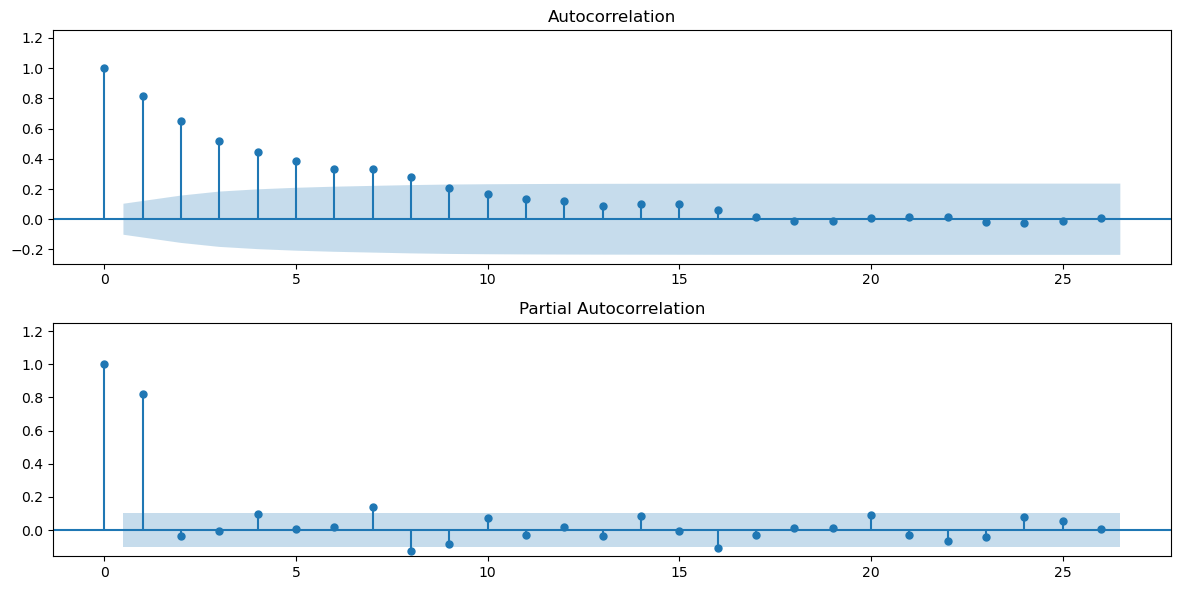

In [311]:
find_start_parameters(df_livorno)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  329
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6133.844
Date:                Wed, 05 Jul 2023   AIC                          12273.688
Time:                        21:22:53   BIC                          12285.076
Sample:                    07-03-2022   HQIC                         12278.231
                         - 05-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.145e+08      3e-11   3.81e+18      0.000    1.15e+08    1.15e+08
ar.L1          0.8203      0.028     29.572      0.000       0.766       0.875
sigma2       9.13e+14   1.26e-17   7.26e+31      0.0

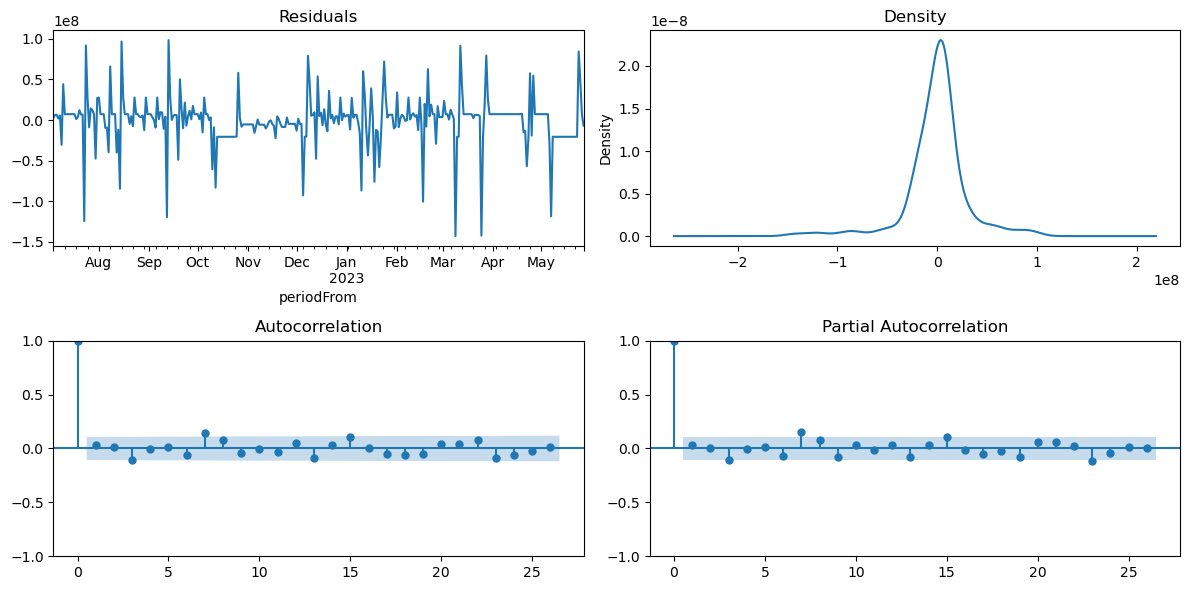

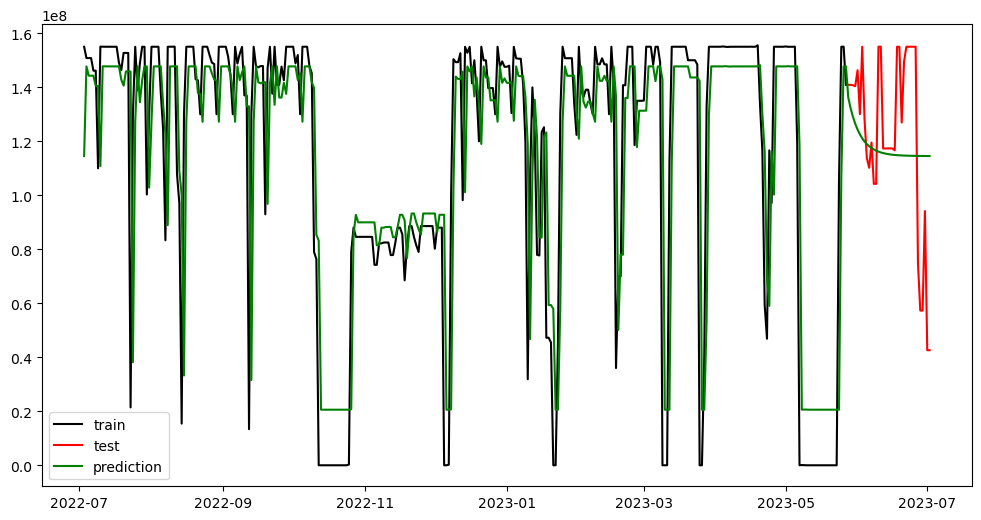

начальная среднеквадратичная ошибка = 48423264.56479526
лучшее значение среднеквадратичной ошибки = 31797269.7695906 при параметрах p = 5, d = 0, q = 4
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  329
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -6127.430
Date:                Wed, 05 Jul 2023   AIC                          12276.860
Time:                        21:24:06   BIC                          12318.616
Sample:                    07-03-2022   HQIC                         12293.518
                         - 05-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.145e+08   4.39e-09   2.61e+16      0.000    

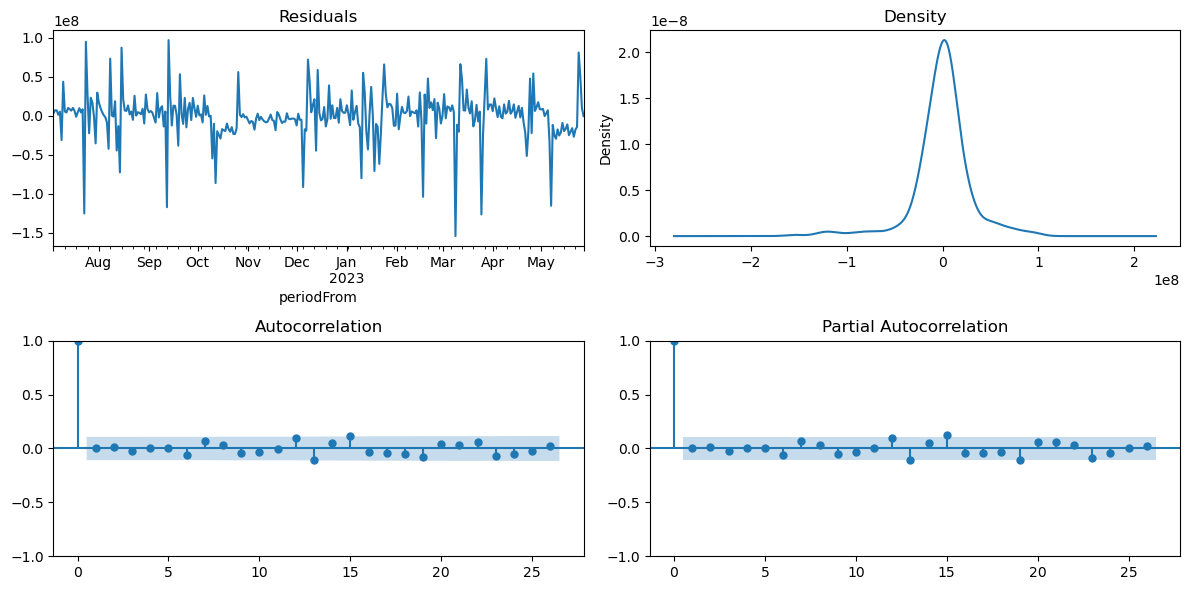

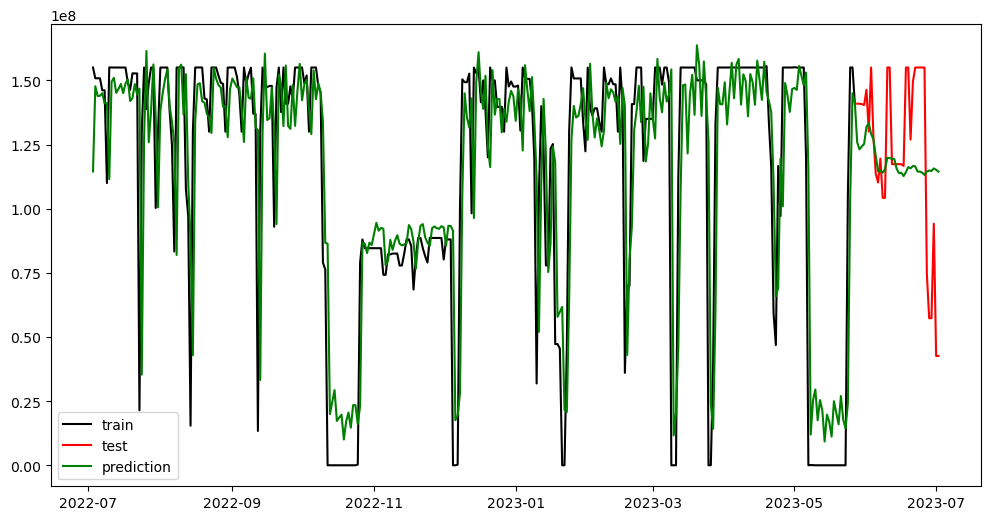

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  365
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -6789.198
Date:                Wed, 05 Jul 2023   AIC                          13600.397
Time:                        21:24:10   BIC                          13643.296
Sample:                    07-03-2022   HQIC                         13617.446
                         - 07-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.153e+08   6.91e-10   1.67e+17      0.000    1.15e+08    1.15e+08
ar.L1          1.2511      0.081     15.542      0.000       1.093       1.409
ar.L2         -0.5457      0.084     -6.490      0.0

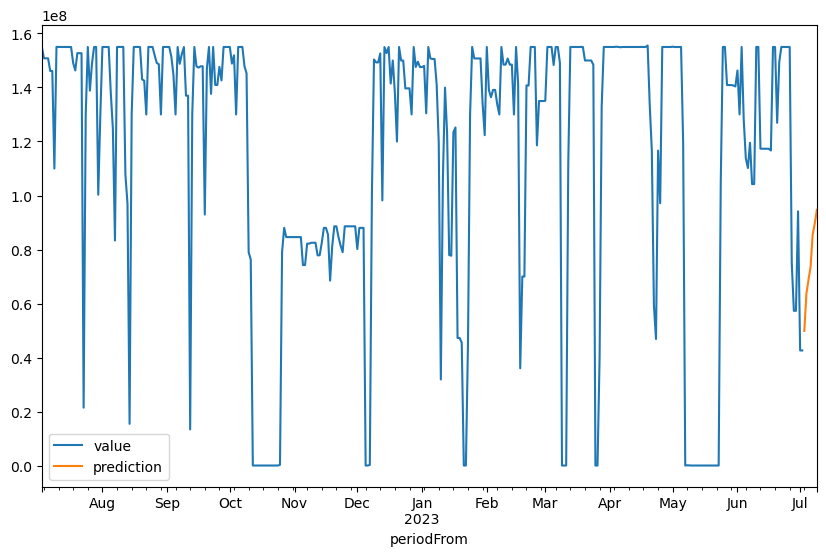

2023-07-03    4.986400e+07
2023-07-04    6.362434e+07
2023-07-05    6.876136e+07
2023-07-06    7.358570e+07
2023-07-07    8.552803e+07
2023-07-08    8.960668e+07
2023-07-09    9.469744e+07
Freq: D, Name: predicted_mean, dtype: float64


In [312]:
build_arima(df_livorno, 1, 0, 0)

In [313]:
df_france = data_preprocessing(pd.read_excel('montoir_de_bretagne_lng_france.xlsx'))
df_france.head()

value
periodFrom         
2022-07-03  1677323
2022-07-04  1662727
2022-07-05  2082312
2022-07-06  2823508
2022-07-07  2999911

порядок дифференцирования = 0


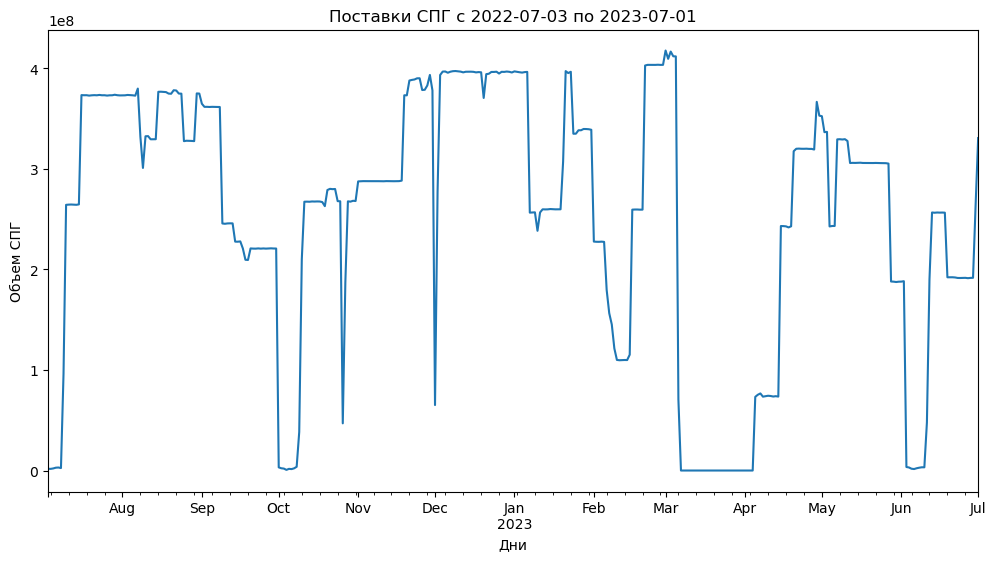

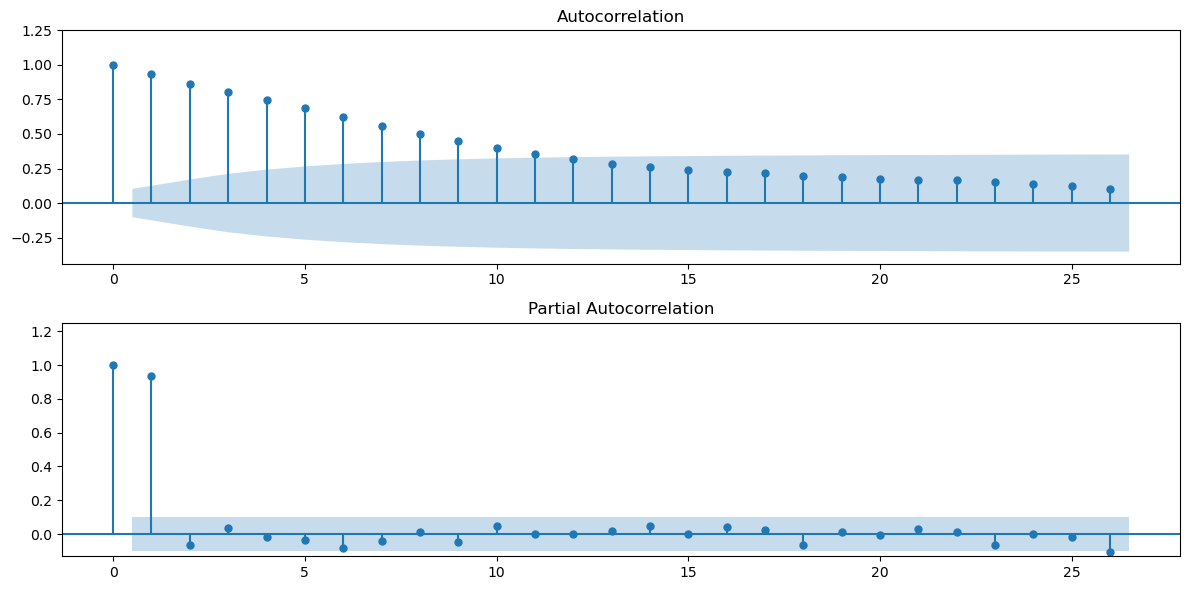

In [314]:
find_start_parameters(df_france)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6243.882
Date:                Wed, 05 Jul 2023   AIC                          12493.763
Time:                        21:27:18   BIC                          12505.142
Sample:                    07-03-2022   HQIC                         12498.303
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.633e+08   1.84e-12   1.43e+20      0.000    2.63e+08    2.63e+08
ar.L1          0.9429      0.017     56.892      0.000       0.910       0.975
sigma2      1.973e+15   3.96e-18   4.98e+32      0.0

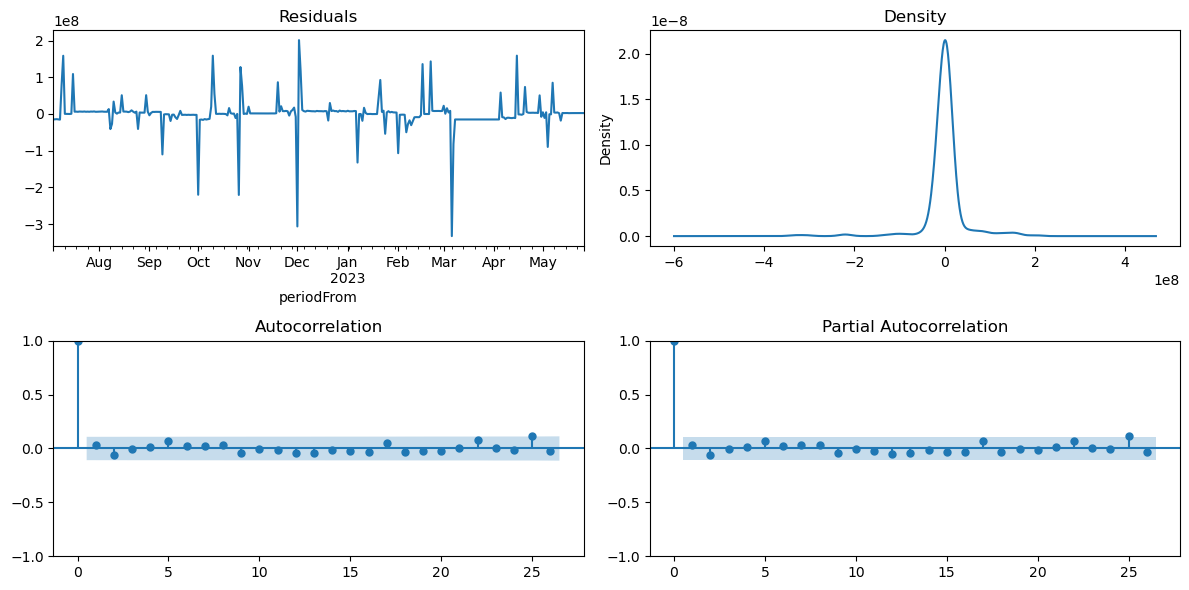

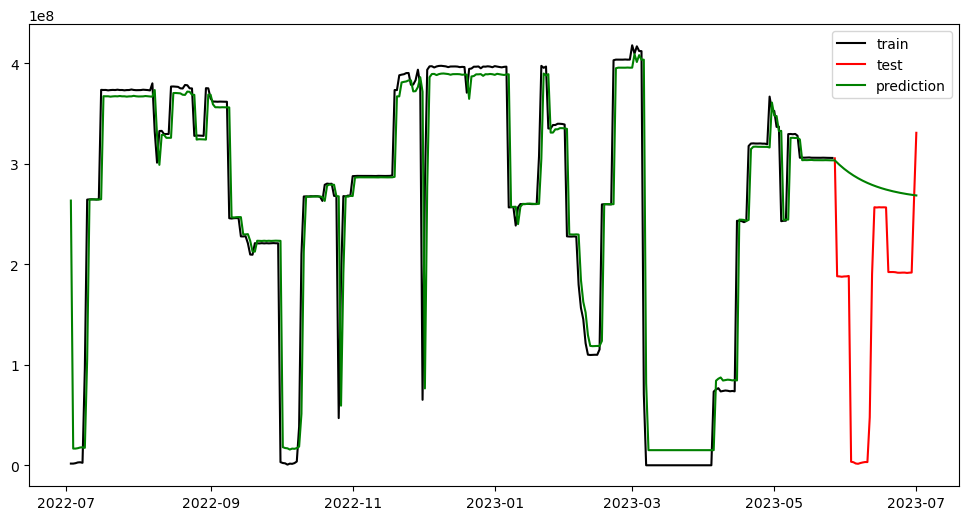

начальная среднеквадратичная ошибка = 48423264.56479526
лучшее значение среднеквадратичной ошибки = 136716457.0432256 при параметрах p = 4, d = 0, q = 4
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  328
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -6236.931
Date:                Wed, 05 Jul 2023   AIC                          12493.861
Time:                        21:28:30   BIC                          12531.791
Sample:                    07-03-2022   HQIC                         12508.994
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.633e+08   1.38e-10    1.9e+18      0.000   

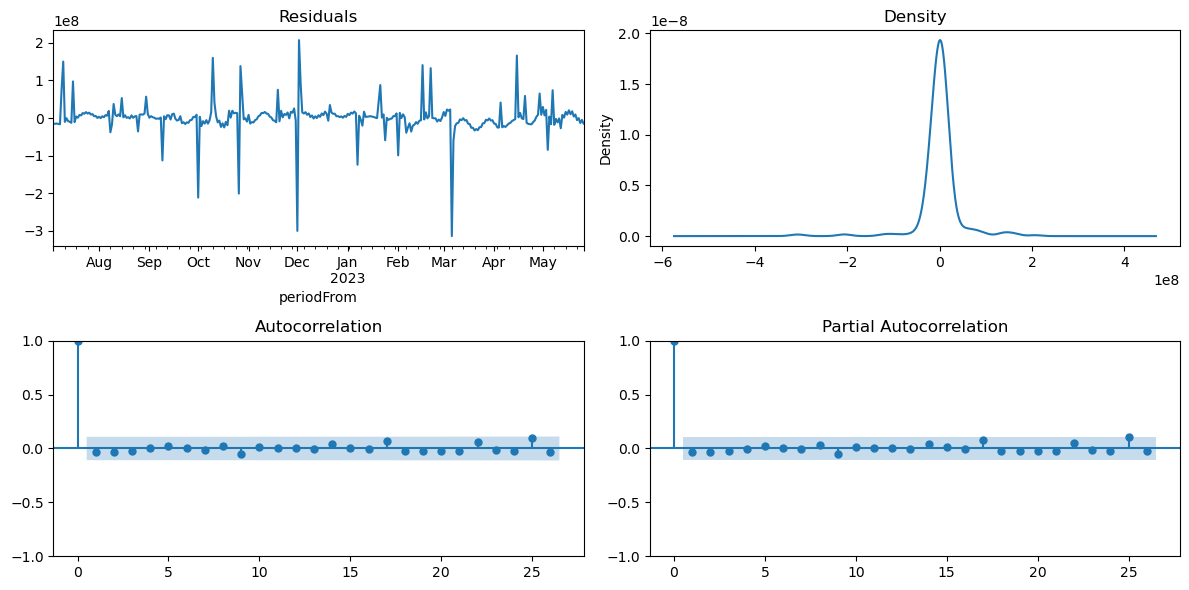

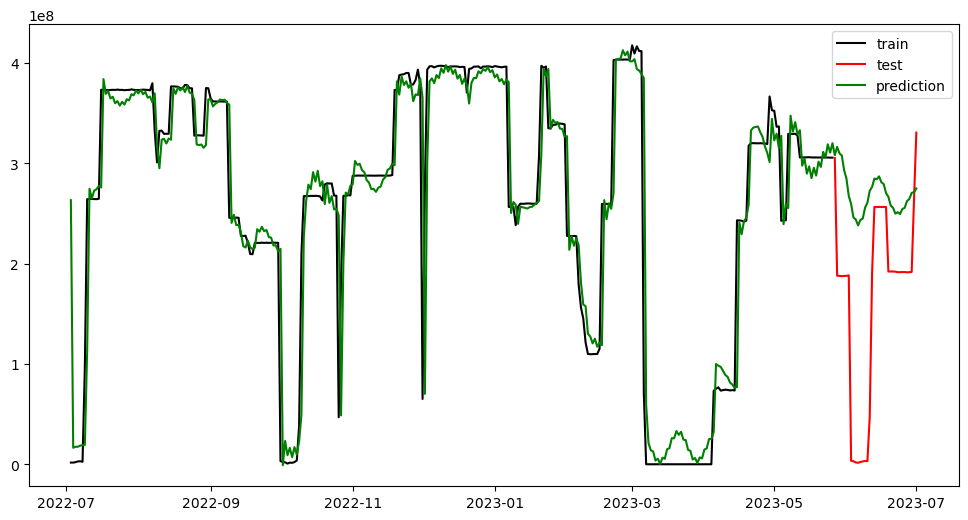

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  364
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -6923.986
Date:                Wed, 05 Jul 2023   AIC                          13867.972
Time:                        21:28:34   BIC                          13906.944
Sample:                    07-03-2022   HQIC                         13883.461
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.535e+08   3.01e-06   8.43e+13      0.000    2.54e+08    2.54e+08
ar.L1          1.7762      5.515      0.322      0.747      -9.034      12.586
ar.L2         -0.0121     15.020     -0.001      0.9

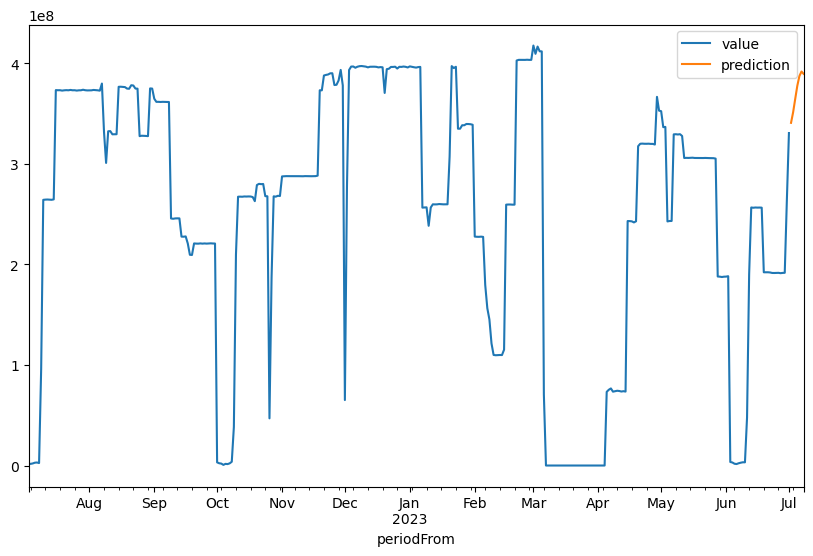

2023-07-02    3.408415e+08
2023-07-03    3.513576e+08
2023-07-04    3.646592e+08
2023-07-05    3.777054e+08
2023-07-06    3.874329e+08
2023-07-07    3.918713e+08
2023-07-08    3.895827e+08
Freq: D, Name: predicted_mean, dtype: float64


In [315]:
build_arima(df_france, 1, 0, 0)

In [316]:
df_sagunto = data_preprocessing(pd.read_excel('sagunto_spain.xlsx'))
df_sagunto.head()

value
periodFrom           
2022-07-03   35732248
2022-07-04   71075875
2022-07-05   98080223
2022-07-06   79156752
2022-07-07  156085953

порядок дифференцирования = 0


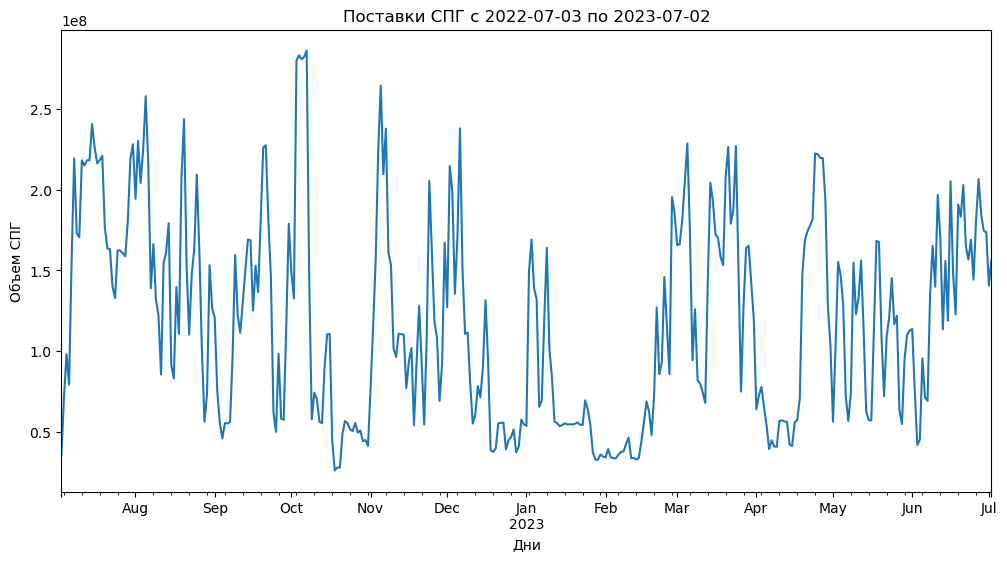

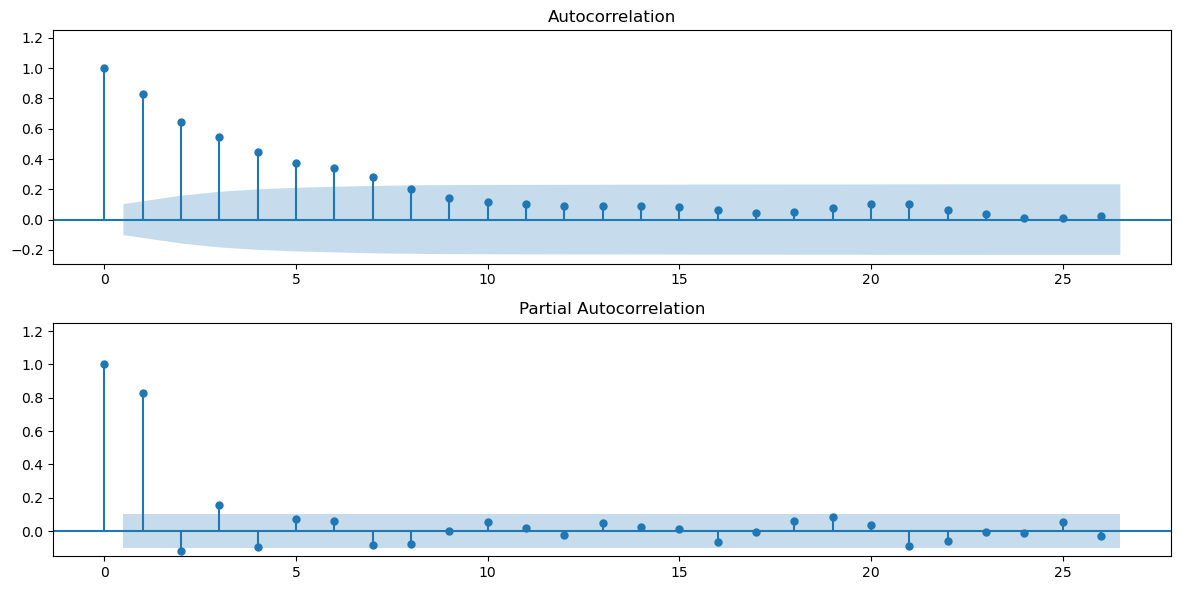

In [317]:
find_start_parameters(df_sagunto)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  329
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -6174.185
Date:                Wed, 05 Jul 2023   AIC                          12360.370
Time:                        21:58:36   BIC                          12383.147
Sample:                    07-03-2022   HQIC                         12369.456
                         - 05-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.162e+08   1.08e-10   1.08e+18      0.000    1.16e+08    1.16e+08
ar.L1          1.0122      0.056     17.996      0.000       0.902       1.122
ar.L2         -0.3568      0.070     -5.084      0.0

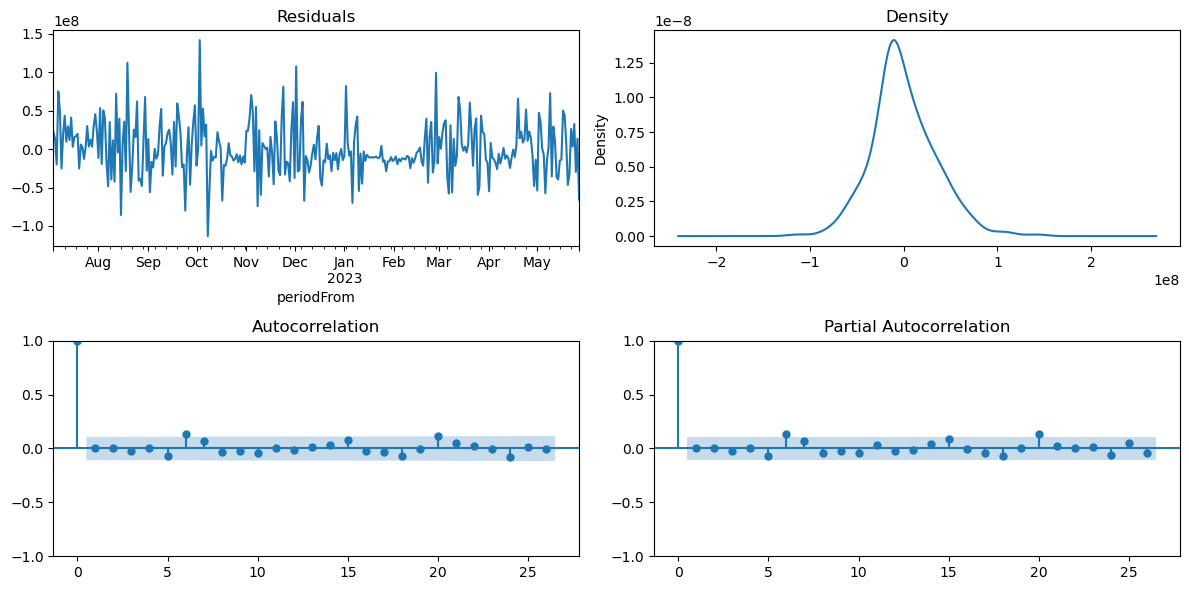

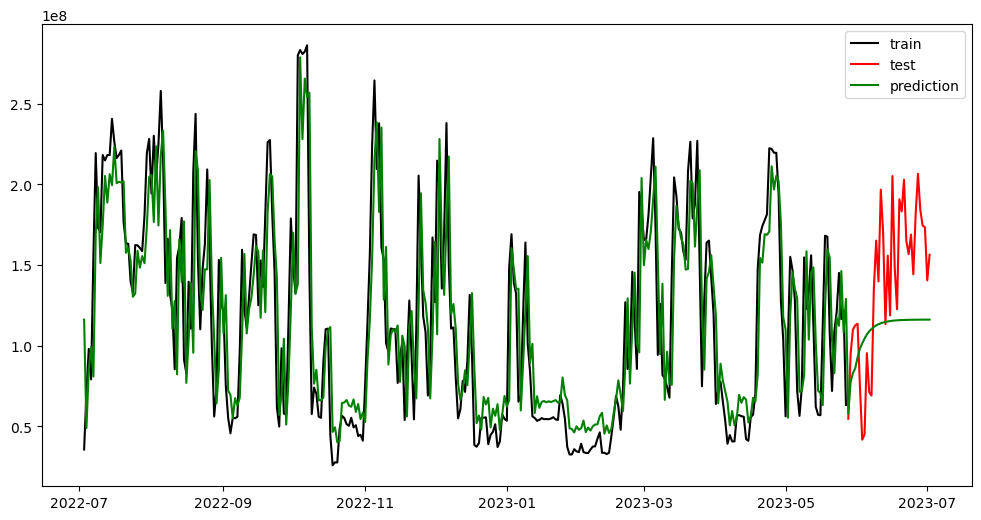

начальная среднеквадратичная ошибка = 48423264.56479526
лучшее значение среднеквадратичной ошибки = 48725220.25930158 при параметрах p = 7, d = 0, q = 1
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  329
Model:                 ARIMA(7, 0, 1)   Log Likelihood               -6169.297
Date:                Wed, 05 Jul 2023   AIC                          12358.594
Time:                        21:59:36   BIC                          12396.555
Sample:                    07-03-2022   HQIC                         12373.738
                         - 05-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.162e+08   5.18e-09   2.25e+16      0.000   

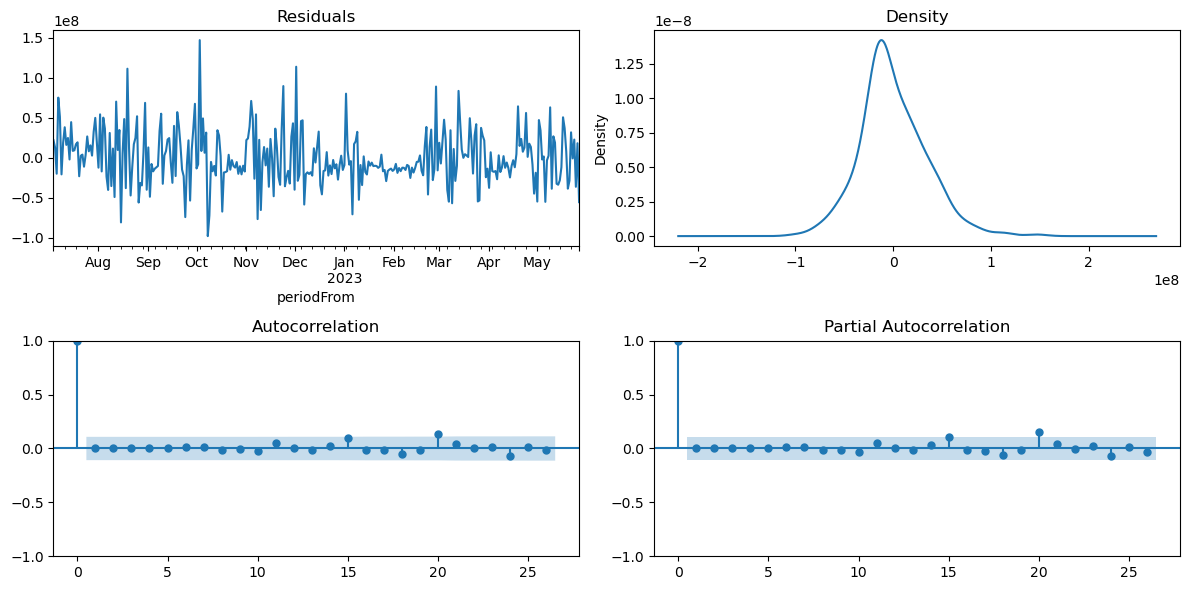

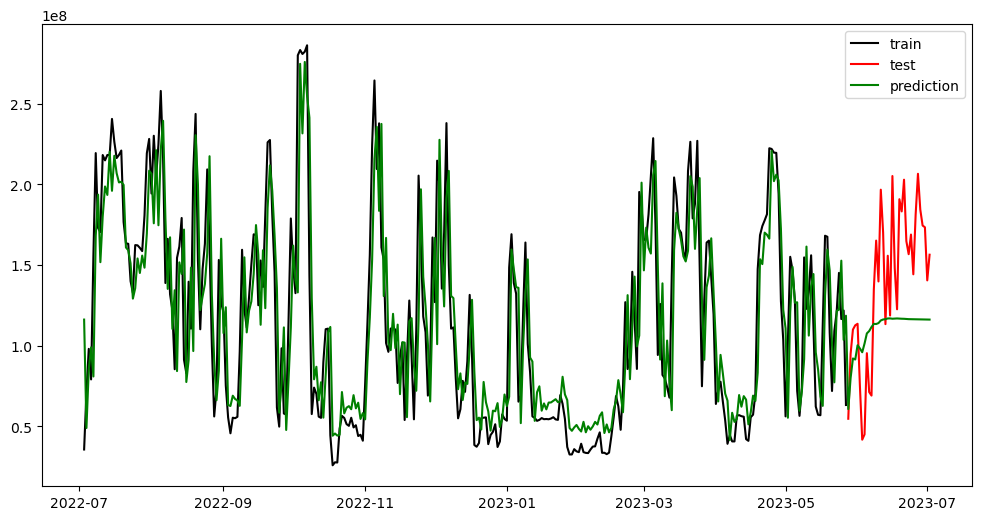

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  365
Model:                 ARIMA(7, 0, 1)   Log Likelihood               -6847.872
Date:                Wed, 05 Jul 2023   AIC                          13715.743
Time:                        21:59:39   BIC                          13754.742
Sample:                    07-03-2022   HQIC                         13731.242
                         - 07-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.184e+08   7.04e-09   1.68e+16      0.000    1.18e+08    1.18e+08
ar.L1          1.3691      0.454      3.014      0.003       0.479       2.259
ar.L2         -0.6863      0.450     -1.525      0.1

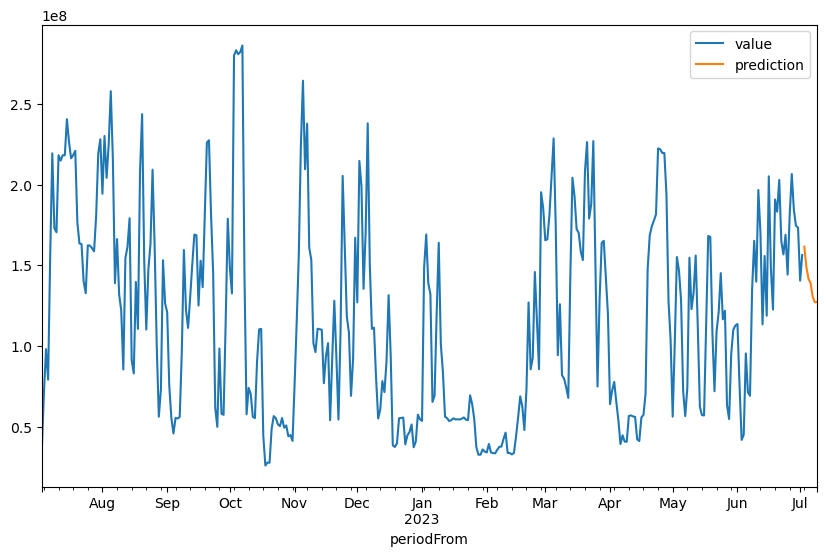

2023-07-03    1.614928e+08
2023-07-04    1.487942e+08
2023-07-05    1.416509e+08
2023-07-06    1.390301e+08
2023-07-07    1.305248e+08
2023-07-08    1.270837e+08
2023-07-09    1.272905e+08
Freq: D, Name: predicted_mean, dtype: float64


In [318]:
build_arima(df_sagunto, 4, 0, 0)

In [326]:
df_poland = data_preprocessing(pd.read_excel('swinoujscie_lng_poland.xlsx'))
df_poland.head()

value
periodFrom           
2022-07-03  220781014
2022-07-04  221879043
2022-07-05  220274514
2022-07-06  203002531
2022-07-07   98122698

порядок дифференцирования = 0


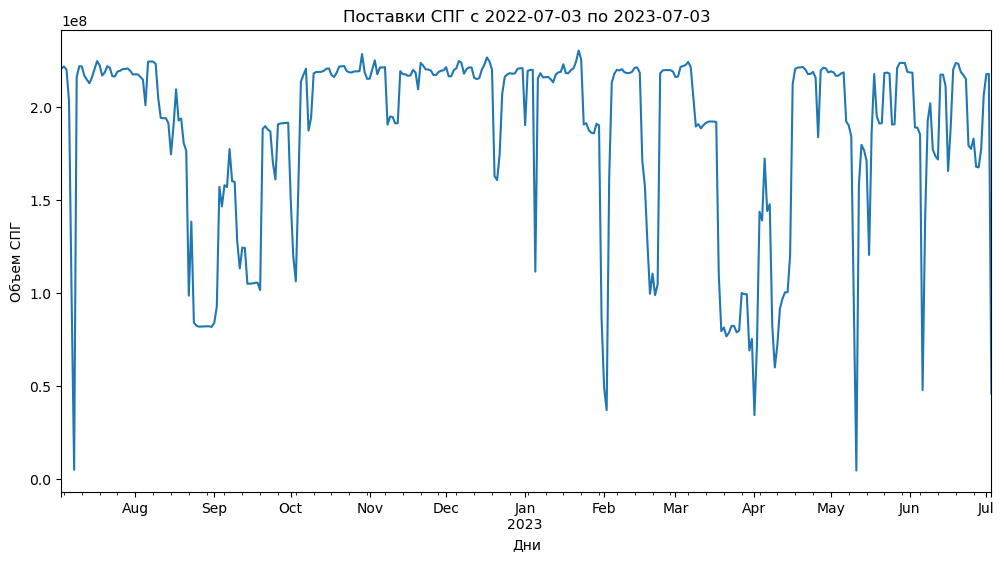

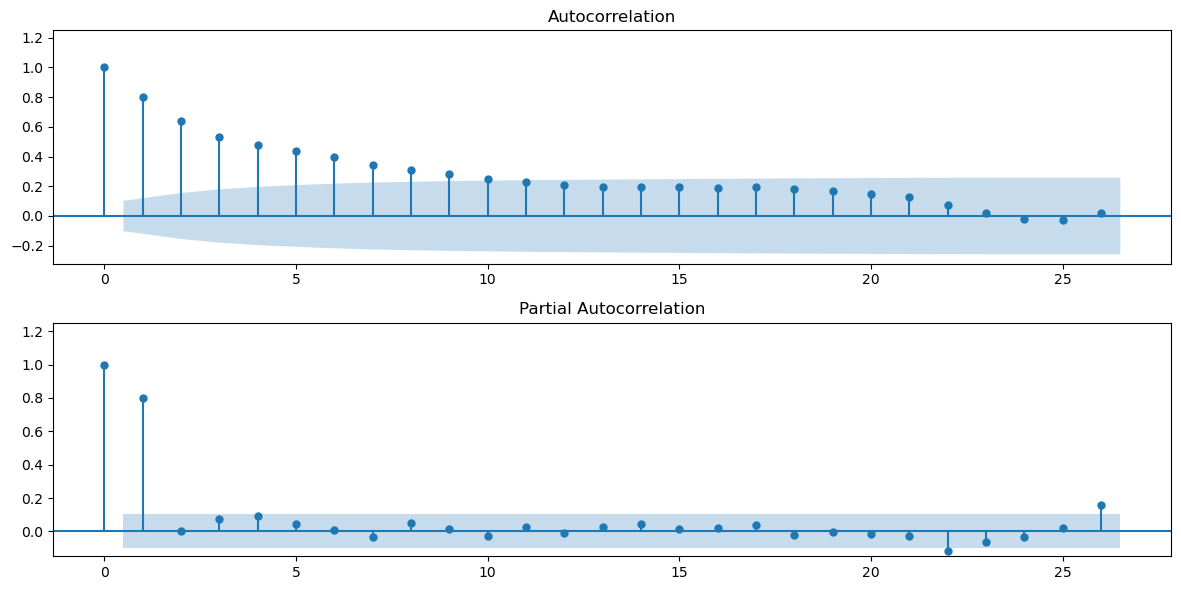

In [327]:
find_start_parameters(df_poland)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  330
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6123.207
Date:                Thu, 06 Jul 2023   AIC                          12252.413
Time:                        10:03:20   BIC                          12263.811
Sample:                    07-03-2022   HQIC                         12256.959
                         - 05-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.855e+08   1.71e-11   1.08e+19      0.000    1.85e+08    1.85e+08
ar.L1          0.8358      0.015     55.030      0.000       0.806       0.866
sigma2      7.646e+14    6.2e-18   1.23e+32      0.0

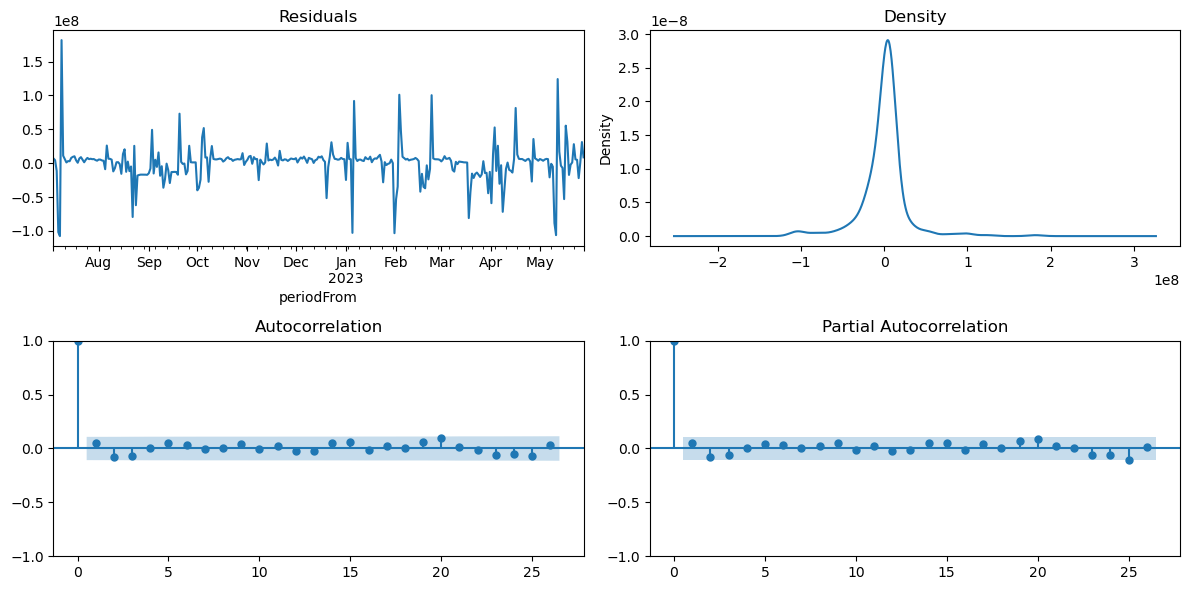

среднее 185929417.85070005
стандартное отклонение 40199408.64202337
коэф доверительного интервала 9.065348752578803


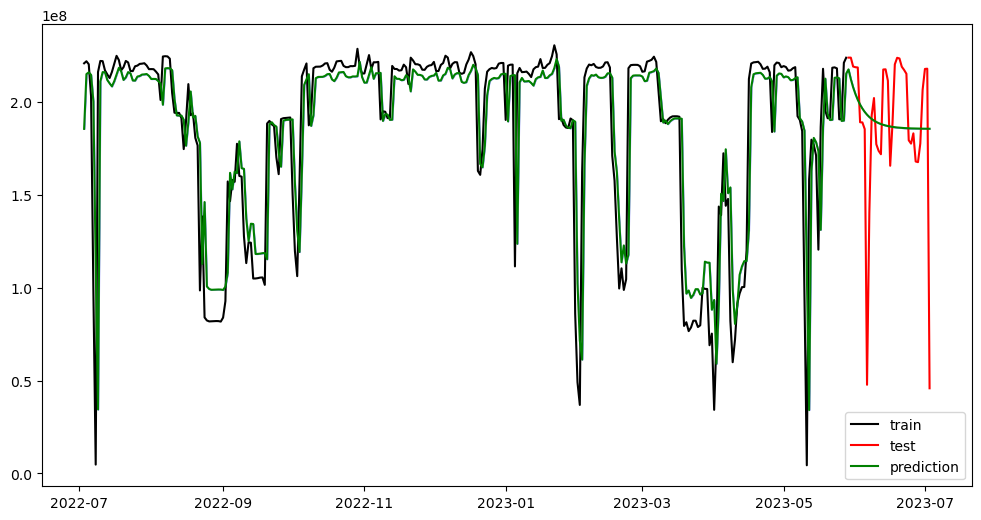

начальная среднеквадратичная ошибка = 48423264.56479526
лучшее значение среднеквадратичной ошибки = 39447151.04959676 при параметрах p = 3, d = 0, q = 7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  330
Model:                 ARIMA(3, 0, 7)   Log Likelihood               -6121.069
Date:                Thu, 06 Jul 2023   AIC                          12266.138
Time:                        10:04:30   BIC                          12311.727
Sample:                    07-03-2022   HQIC                         12284.323
                         - 05-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.855e+08   2.19e-10   8.48e+17      0.000   

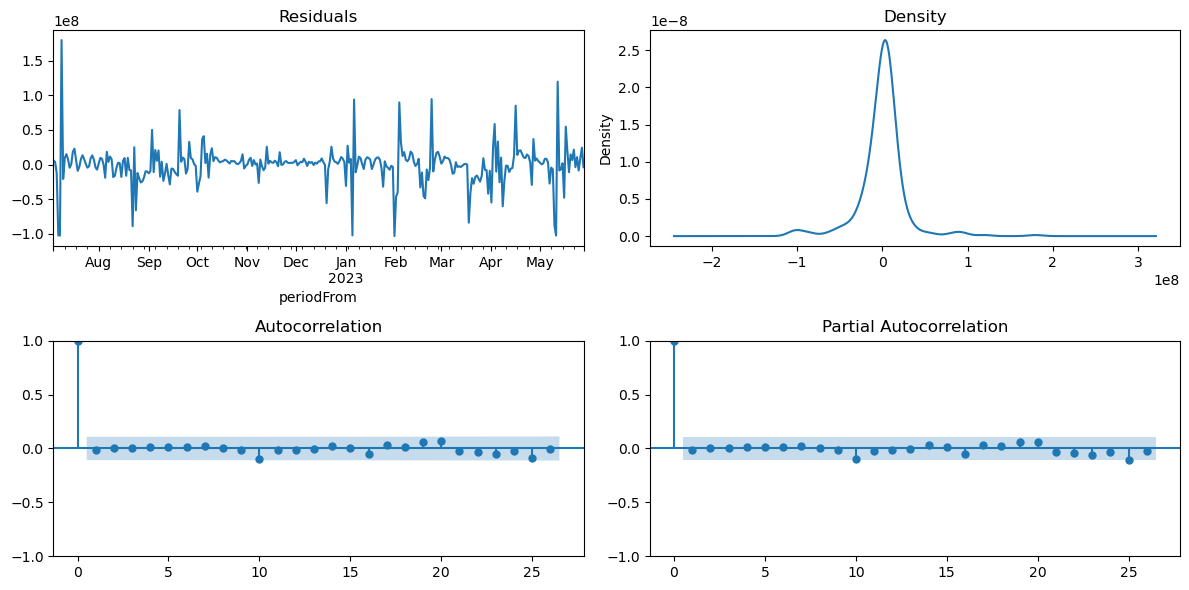

среднее 186329229.26505664
стандартное отклонение 41431578.10278328
коэф доверительного интервала 8.814660364939789


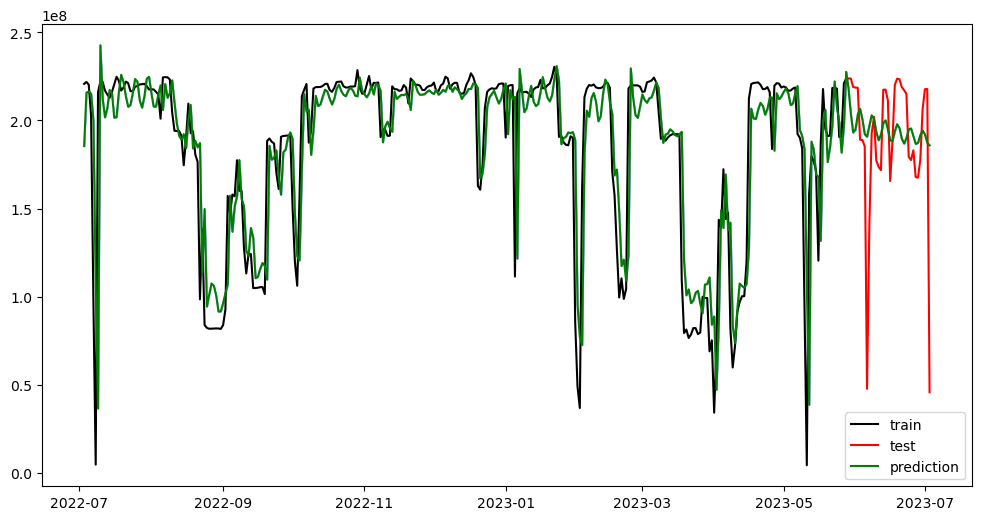

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  366
Model:                 ARIMA(3, 0, 7)   Log Likelihood               -6809.576
Date:                Thu, 06 Jul 2023   AIC                          13643.152
Time:                        10:04:33   BIC                          13689.984
Sample:                    07-03-2022   HQIC                         13661.762
                         - 07-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.859e+08   5.85e-08   3.18e+15      0.000    1.86e+08    1.86e+08
ar.L1          1.1174      1.109      1.008      0.314      -1.056       3.290
ar.L2         -0.6215      1.198     -0.519      0.6

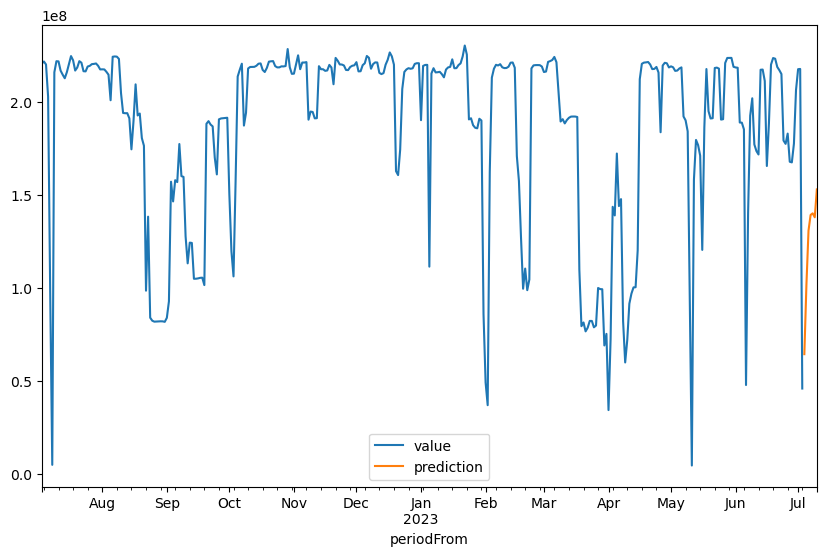

2023-07-04    6.431263e+07
2023-07-05    1.018203e+08
2023-07-06    1.308584e+08
2023-07-07    1.392587e+08
2023-07-08    1.401412e+08
2023-07-09    1.380053e+08
2023-07-10    1.530158e+08
Freq: D, Name: predicted_mean, dtype: float64


In [337]:
build_arima(df_poland, 1, 0, 0)